<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Feature Engineering </h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

O objetivo neste notebook é criação novas variáveis (features) que possam ajudar na identificação de novos padrões, com a finalidade de bater a baseline estabelecida no notebook anterior de RMSE 247.78 com XGBoost na competição. 



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [2]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q optbinning
    !pip install --q optuna  
    !pip install --q catboost
    !pip install --q pandas-profiling
    !pip install --q feature_engine
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [3]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import shap

In [4]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import statsmodels.api   as sm
import xgboost           as xgb
import scikitplot        as skplt

In [5]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing   import PowerTransformer, Normalizer
from sklearn.preprocessing   import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                 import metrics
from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix
from datetime                import datetime

In [6]:
from sklearn.cluster         import KMeans
from sklearn.decomposition   import PCA

In [7]:
from sklearn.ensemble        import VotingRegressor
from sklearn.compose         import TransformedTargetRegressor
from sklearn.pipeline        import Pipeline
from scipy.stats             import skew, norm
from scipy.stats             import norm

In [8]:
from yellowbrick.cluster        import KElbowVisualizer, SilhouetteVisualizer
from sklearn.utils.class_weight import compute_sample_weight
from scipy                      import stats
from scipy.cluster              import hierarchy as hc
from math                       import factorial
from scipy.stats                import mode
from collections                import Counter
from sklearn.neighbors          import KNeighborsClassifier
from optbinning                 import OptimalBinning

In [9]:
from yellowbrick.regressor       import ResidualsPlot
from yellowbrick.regressor       import PredictionError
from yellowbrick.model_selection import ValidationCurve

In [10]:
from lightgbm                        import LGBMRegressor
from sklearn.linear_model            import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble                import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble                import AdaBoostRegressor
from sklearn.linear_model            import LinearRegression
from sklearn.kernel_ridge            import KernelRidge
from itertools                       import product
from sklearn.linear_model            import Ridge
from sklearn.neighbors               import KNeighborsRegressor
from sklearn.ensemble                import ExtraTreesRegressor 
from catboost                        import CatBoostRegressor
#from pycaret.regression              import * 
from sklearn.ensemble                import IsolationForest
from sklearn.covariance              import EllipticEnvelope
from sklearn.preprocessing           import FunctionTransformer
#from feature_engine.outlier_removers import Winsoriz

In [11]:
from sklearn.compose      import TransformedTargetRegressor
from sklearn.pipeline     import FeatureUnion, Pipeline, make_pipeline
from sklearn.base         import BaseEstimator, TransformerMixin

## 1.3. Funções

In [15]:
class Ultil():
    
    import sklearn.exceptions
    
    def __init__(self):
        pass
    
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', None)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.3*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     

            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        #ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        #y_fmt = tick.FormatStrFormatter('%.0f') 
        #ax.yaxis.set_major_formatter(y_fmt)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)

        graf_label(ax, total)

    def graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache():

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(Ultil.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))

    def plot_roc_curve(fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(y_, predictions_):
        mae  = metrics.mean_absolute_error(y_, predictions_)
        mse  = metrics.mean_squared_error(y_, predictions_)
        rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape = metrics.mean_absolute_percentage_error(y_, predictions_)
        r2   = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2

icecream, colors, color_cols = Ultil.jupyter_setting()

In [16]:
def reduce_memory_usage(df, verbose=True):
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    for col in df.columns:
        
        col_type = df[col].dtypes
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
        
    return df

In [ ]:
def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()

In [ ]:
def graf_label(ax, total):
    
     for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        width, height = i.get_width() -.2 , i.get_height()
        
        x, y  = i.get_xy()  
        color = 'white'
        alt   = .5
        soma  = 0 

        if height < 70:
            color = 'black'
            alt   = 1
            soma  = 10

        ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                    (i.get_x()+.3*width, 
                     i.get_y()+soma + alt*height),
                     color   = color,
                     weight = 'bold',
                     size   = 14)

In [ ]:
def scaler_MaxAbsScaler_StandardScaler(df):    
    sc_mm = MaxAbsScaler()
    sc_st = StandardScaler()     
    col = df.columns
    df  = sc_mm.fit_transform(df)
    df  = pd.DataFrame(sc_st.fit_transform(df), columns=col)    
    return df

In [ ]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

In [ ]:
def free_gpu_cache():
    
    # https://www.kaggle.com/getting-started/140636
    #print("Initial GPU Usage")
    #gpu_usage()                             

    #cuda.select_device(0)
    #cuda.close()
    #cuda.select_device(0)   
    
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:

def graf_feature_corr(df_, annot_=False, threshold_=.8, print_var_=False, print_graf_=True, mask_=True, title_=''):
    
    df = df_.corr(method ='pearson').round(5)

    if print_graf_: 
        # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
        mask = np.zeros_like(df)
        mask[np.triu_indices_from(mask)] = mask_

        # Making a plot
        ax = sns.heatmap(df, annot=annot_, 
                         mask=mask, 
                         cmap="RdBu", 
                         annot_kws={"weight": "bold", "fontsize":13}
                        )

        ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

        plt.setp(ax.get_xticklabels(), 
                 rotation      = 90, 
                 ha            = "right",
                 rotation_mode = "anchor", 
                 weight        = "normal")

        plt.setp(ax.get_yticklabels(), 
                 weight        = "normal",
                 rotation_mode = "anchor", 
                 rotation      = 0, 
                 ha            = "right")
                
        plt.show();

    if print_var_:         
        df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
        if len(df_corr)>0:            
            print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
            df_corr.columns =  ['var_1', 'var_2', 'corr']
            display(df_corr)
        else: 
            print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for {}'.format(label))
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [ ]:
def evaluation(y_, predictions_):
    mae  = metrics.mean_absolute_error(y_, predictions_)
    mse  = metrics.mean_squared_error(y_, predictions_)
    rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
    mape = metrics.mean_absolute_percentage_error(y_, predictions_)
    r2   = metrics.r2_score(y_, predictions_)    
    return rmse, mae, mse, mape, r2

## 1.4. Criar estrutura de pasta 


In [17]:
path        = '/content/drive/MyDrive/Flai/09/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'aluguéis'
path_automl = 'automl/'

In [18]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [19]:
df1_train     = pd.read_csv(path + path_data + 'treino.csv')
df1_test      = pd.read_csv(path + path_data + 'teste.csv')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((4500, 11), (3000, 10), (3000, 1))

### 1.5.3. Visualizar os dados 

In [20]:
df1_train.head()

,hora,dia,feriado,estação,temperatura,chuva,umidade,sol,visibilidade,vento,aluguéis
0,16,sábado,não,verão,39.4,0.0,61.1,2.19,92.0%,3.49,1318
1,21,sexta,não,primavera,22.2,0.0,63.3,0.00,32.0%,2.89,686
2,16,segunda,não,verão,40.5,0.0,52.8,2.51,93.0%,3.97,831
3,7,segunda,sim,outono,25.6,0.0,70.9,0.00,97.0%,1.09,15
4,9,segunda,não,verão,39.9,0.0,58.1,1.69,62.0%,1.09,865


In [21]:
df1_test.head()

,hora,dia,feriado,estação,temperatura,chuva,umidade,sol,visibilidade,vento
0,21,quinta,não,verão,33.3,0.12,72.4,0.0,88.0%,2.05
1,0,segunda,não,outono,25.0,0.00,73.1,0.0,34.0%,0.85
2,4,segunda,não,outono,22.1,0.00,67.9,0.0,97.0%,1.09
3,6,terça,não,verão,36.5,0.00,80.7,0.0,53.0%,1.93
4,21,quinta,não,verão,34.2,0.00,65.6,0.0,71.0%,2.05


In [22]:
df1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hora          4500 non-null   int64  
 1   dia           4500 non-null   object 
 2   feriado       4500 non-null   object 
 3   estação       4500 non-null   object 
 4   temperatura   4500 non-null   float64
 5   chuva         4500 non-null   float64
 6   umidade       4500 non-null   float64
 7   sol           4500 non-null   float64
 8   visibilidade  4500 non-null   object 
 9   vento         4500 non-null   float64
 10  aluguéis      4500 non-null   int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 386.8+ KB


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. PROCESSAMENTO </h1>    
</div>

In [23]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

df2_train.shape, df2_test.shape

((4500, 11), (3000, 10))

## 2.1. Tratar variável visibilidade

In [24]:
def convert_visibilidade(df_):    
    list_visibilidade = []
    for c in df_['visibilidade'].values: 
        list_visibilidade.append(np.float64( c.replace('%', '')))        
    df_['visibilidade']= list_visibilidade    
    return df_

In [25]:
df2_train = convert_visibilidade(df2_train.copy())
df2_test  = convert_visibilidade(df2_test.copy())

In [26]:
df2_train.head()

,hora,dia,feriado,estação,temperatura,chuva,umidade,sol,visibilidade,vento,aluguéis
0,16,sábado,não,verão,39.4,0.0,61.1,2.19,92.0,3.49,1318
1,21,sexta,não,primavera,22.2,0.0,63.3,0.00,32.0,2.89,686
2,16,segunda,não,verão,40.5,0.0,52.8,2.51,93.0,3.97,831
3,7,segunda,sim,outono,25.6,0.0,70.9,0.00,97.0,1.09,15
4,9,segunda,não,verão,39.9,0.0,58.1,1.69,62.0,1.09,865


In [27]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   hora          4500 non-null   int64  
 1   dia           4500 non-null   object 
 2   feriado       4500 non-null   object 
 3   estação       4500 non-null   object 
 4   temperatura   4500 non-null   float64
 5   chuva         4500 non-null   float64
 6   umidade       4500 non-null   float64
 7   sol           4500 non-null   float64
 8   visibilidade  4500 non-null   float64
 9   vento         4500 non-null   float64
 10  aluguéis      4500 non-null   int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 386.8+ KB



<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. FEATURE ENGINEERING </h1>    
</div>

Nesta parte do processo vamos criar diversas variávies com a finalidade de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial **fe_**, a cada criação de novas variáveis vamos treinar um conjunto de  modelos e analisar a performance das novas variáveis na identifição de novos padrões.

Vamos criar três datasets para treinar os classficadores, são eles os seguintes: 
1. **dataset misto** com variáveis categóricas que foram transformadas em dammi e ordinal; 
2. **dataset ordinal** com todas as variáveis categóricas como ordinal; 
3. **dataset dammy** com todas as variáveis categóricas transformadas em dammi

In [28]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

In [30]:
feature_all   = df3_test.columns.to_list()
feature_float = df3_test.select_dtypes(np.number).columns.to_list()
feature_cat   = df3_test.select_dtypes(object).columns.to_list()

print('Variáveis Númericas')
print(feature_float,)
print()
print('Variáveis Categóricas')
print(feature_cat)

Variáveis Númericas
['hora', 'temperatura', 'chuva', 'umidade', 'sol', 'visibilidade', 'vento']

Variáveis Categóricas
['dia', 'feriado', 'estação']


## 3.1. Variáveis Qualitativas

Vamos criar uma função para tratamento e geração das novas variáveis. 

In [31]:
def feature_binarizer(df_tr_, df_vl_, df_ts_, features_ohe_=None, feature_ord_=None):

    if features_ohe_ is not None:
        for col in features_ohe_:         
            lb   = OneHotEncoder(sparse=False) # LabelBinarizer() OneHotEncoder
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )

            df_lb_tr = pd.DataFrame(lb.fit_transform (df_tr_[[col]]), columns=cols_fe)
            df_lb_vl = pd.DataFrame(lb.transform (df_vl_[[col]]), columns=cols_fe)
            df_lb_ts = pd.DataFrame(lb.transform (df_ts_[[col]]), columns=cols_fe)
            
            df_lb_tr[cols_fe]= df_lb_tr[cols_fe].astype(int)
            df_lb_vl[cols_fe]= df_lb_vl[cols_fe].astype(int)
            df_lb_ts[cols_fe]= df_lb_ts[cols_fe].astype(int)

            df_lb_tr.index =  df_tr_.index
            df_lb_vl.index =  df_vl_.index
            df_lb_ts.index =  df_ts_.index

            df_tr_ = pd.concat([df_tr_, df_lb_tr], axis=1)
            df_vl_ = pd.concat([df_vl_, df_lb_vl], axis=1)
            df_ts_ = pd.concat([df_ts_, df_lb_ts], axis=1)

            df_tr_.drop(col, axis=1, inplace=True)
            df_vl_.drop(col, axis=1, inplace=True)
            df_ts_.drop(col, axis=1, inplace=True)

    col     = ''
    cols_fe = ''

    if feature_ord_ is not None:
        for col in feature_ord_:
            ordEncoder = OrdinalEncoder()            
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )
                
            df_tr_[col] = ordEncoder.fit_transform(df_tr_[[col]])
            df_vl_[col] = ordEncoder.transform (df_vl_[[col]])
            df_ts_[col] = ordEncoder.transform (df_ts_[[col]])

    return df_tr_, df_vl_, df_ts_

In [32]:
cols_oho_01 = ['estação','feriado'] 
cols_ord_01 = ['dia']
cols_oho_02 = [] 
cols_ord_02 = ['dia', 'estação','feriado']
cols_oho_03 = ['dia', 'estação','feriado'] 
cols_ord_03 = []


df3_tr_01_mista, _, df3_ts_01_mista = \
    feature_binarizer(df3_train.copy(), df3_train.copy(), df3_test.copy(), cols_oho_01, cols_ord_01)

df3_tr_02_ord_Encoder, _, df3_ts_02_ord_Encoder = \
    feature_binarizer(df3_train.copy(), df3_train.copy(), df3_test.copy(),cols_oho_02, cols_ord_02)

df3_tr_03_one_hot, _, df3_ts_03_one_hot = \
    feature_binarizer(df3_train.copy(), df3_train.copy(), df3_test.copy(),cols_oho_03, cols_ord_03)

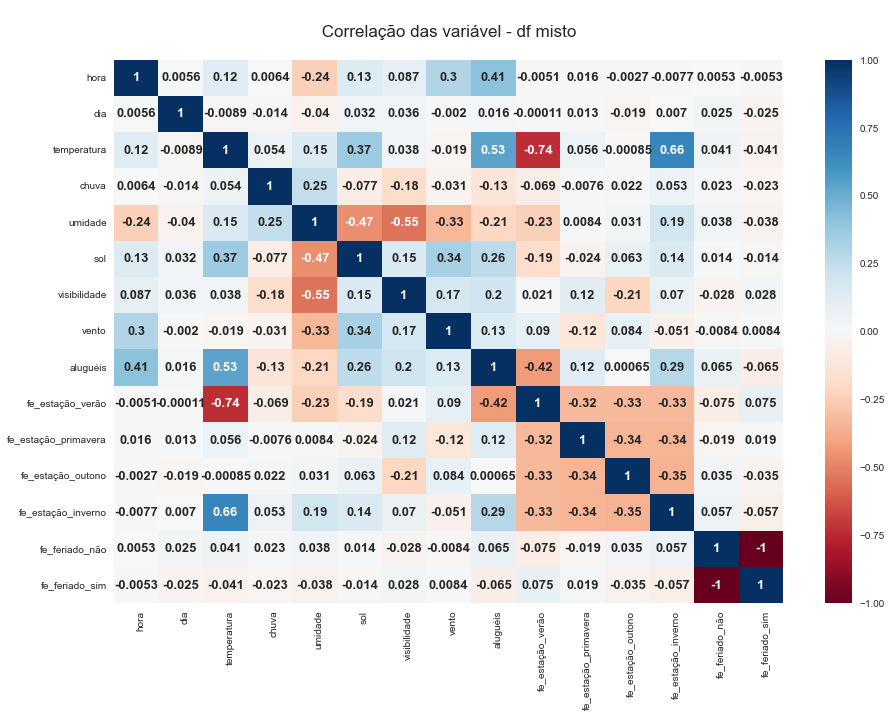

Variáveis autocorrelacionadas threshold=0.70


,var_1,var_2,corr
0,temperatura,fe_estação_verão,-0.73861
1,fe_estação_verão,temperatura,-0.73861
2,fe_feriado_não,fe_feriado_sim,-1.00000
3,fe_feriado_sim,fe_feriado_não,-1.00000


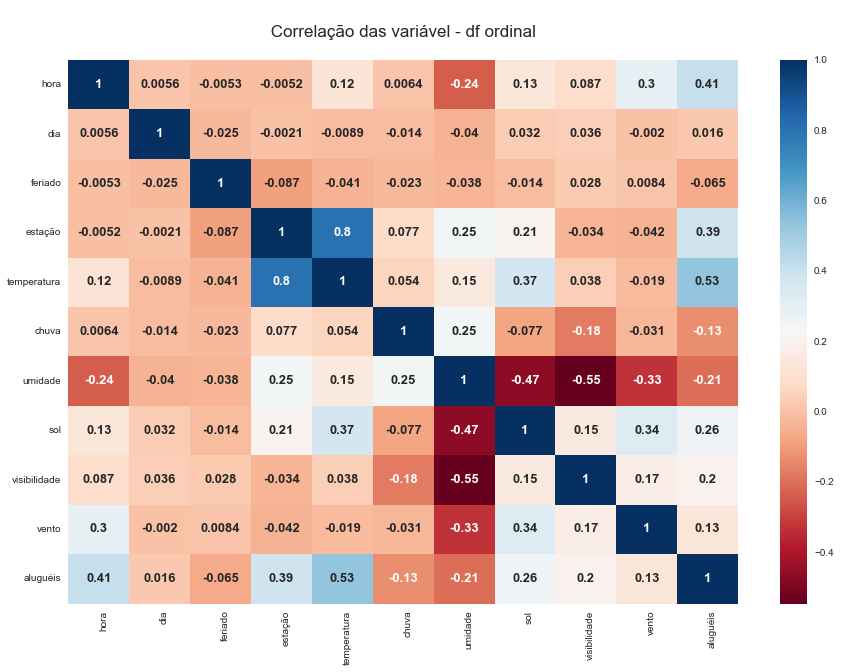

Variáveis autocorrelacionadas threshold=0.70


,var_1,var_2,corr
0,estação,temperatura,0.80329
1,temperatura,estação,0.80329


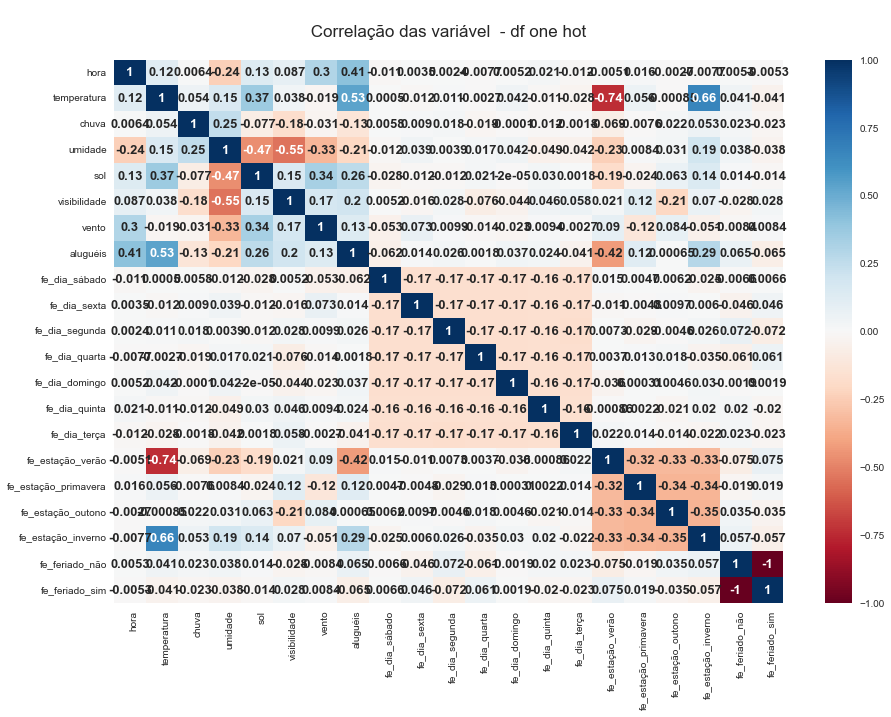

Variáveis autocorrelacionadas threshold=0.70


,var_1,var_2,corr
0,temperatura,fe_estação_verão,-0.73861
1,fe_estação_verão,temperatura,-0.73861
2,fe_feriado_não,fe_feriado_sim,-1.00000
3,fe_feriado_sim,fe_feriado_não,-1.00000


In [33]:
df    = [df3_tr_01_mista, df3_tr_02_ord_Encoder, df3_tr_03_one_hot]
title = ['- df misto', '- df ordinal', ' - df one hot']

for i, df_ in enumerate(df): 
    plt.figure(figsize=(15,10))
    Ultil.graf_feature_corr(df_         = df_.copy(), 
                            annot_      = True, 
                            threshold_  = .7, 
                            print_var_  = True, 
                            print_graf_ = True, 
                            mask_       = False,
                            title_      = title[i]);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Nos datasets criados temos variáveis com correlação acima de 70%, negativa ou positiva, neste primeiro momento vamos deixa essa variáveis, no processo de seleção das variáveis (**feature selection**) podemos fazer a remoção de algumas variáveis, caso alguma das variáveis não seja necessária na modelagem.         
</div>

### 3.1.1. Modelagem

In [34]:
 def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))

In [35]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target] = y_pred_test_
            df_submission.to_csv(path + 'Data/submission/' + model_name_+ '.csv', index=False)

In [36]:
def feature_winsorize_target(y_tr_, perc_lower_limit_=.05, perc_upper_limit_=.99):
      
    if perc_lower_limit_ is not None:
        lower_limit_ = y_tr_.quantile(perc_lower_limit_)
        y_tr_[y_tr_<lower_limit_]  = lower_limit_                

    if perc_upper_limit_ is not None:
        upper_limit_ = y_tr_.quantile(perc_upper_limit_)
        y_tr_[y_tr_>upper_limit_]  = upper_limit_

    return y_tr_ 

In [37]:
def model_fit(models_, datasets_, target_, path_, feature_drop_cor_=[], scalers_=[None], 
              seed_=12359, transf_target_=None, winsorize_=False, perc_lower_limit_=None,
              perc_upper_limit_=None, feature_scaler_=None, test_size_=0.2):
    
    df_pred_final = pd.DataFrame()
    
    scaler_best    = None
    model_best     = None
    count_datase_1 = 0
    count_datase_2 = 0
    count_datase_3 = 0
    score_best     = np.mean(datasets_[0][0][target_])

    
    for ii , mdl in enumerate(models_):
        
        model      = mdl[0]
        model_name = mdl[1]
        type_model = mdl[2]
               
        for i, df in enumerate(datasets_): 
            
            clf_name    = model.__class__.__name__
            df_tr       = datasets_[i][0]
            df_ts       = datasets_[i][1]
            df_name     = datasets_[i][2]   
            num_dataset = datasets_[i][3]   

            model_name_ = model_name + '_' + str(i)
            
            delete_files(model_name_)

            X      = df_tr.drop(target_, axis=1).copy()
            X      = X.drop(feature_drop_cor_, axis=1).copy()
            y      = df_tr[target_]
            X_test = df_ts.drop(feature_drop_cor_, axis=1).copy()

            X_train, X_valid, y_train, y_valid = \
                train_test_split(X, y, 
                                 test_size    = test_size_,
                                 shuffle      = True, 
                                 #stratify     = y, 
                                 random_state = seed_)   
            
            model_baseline = model
            cols           = X_valid.columns.to_list()  
            n_estimators   = 0 if type_model>1 else int(model.get_params()['n_estimators']*.1)

            print('Model: {} -> {}'.format(model.__class__.__name__, df_name))

            
            if winsorize_:                   
                y_train = feature_winsorize_target(y_tr_            = y_train, 
                                                   perc_lower_limit_= perc_lower_limit_, 
                                                   perc_upper_limit_= perc_upper_limit_)
                
            for i , scaler in enumerate(scalers_):
                
                X_train_s = X_train.copy() 
                X_valid_s = X_valid.copy()
                X_test_s  = X_test.copy()      
                
                if scaler!=None:      
                    scaler.fit(X_train_s[cols])
                    X_train_s[cols] = scaler.transform(X_train_s[cols])
                    X_valid_s[cols] = scaler.transform(X_valid_s[cols])
                    X_test_s[cols]  = scaler.transform(X_test[cols])
                                
                y_train_nor = y_train
                y_valid_nor = y_valid        
                
                if transf_target_ is not None:                     
                    transf_target_.fit(y_train_nor.values.reshape(-1,1))
                    y_train_nor = transf_target_.transform(y_train_nor.values.reshape(-1,1))
                    y_valid_nor = transf_target_.transform(y_valid_nor.values.reshape(-1,1)) 
                    
                if type_model==1:
                    eval_set = [(X_train_s, y_train_nor), (X_valid_s, y_valid_nor)]
                    model.fit(X_train_s, 
                              y_train_nor, 
                              #eval_metric           = 'rmse', 
                              eval_set              = eval_set,                                               
                              verbose               = False,                                                       
                              early_stopping_rounds = n_estimators)
                
                if type_model==2: 
                    model.fit(X_train_s, y_train_nor) 
                    
                if type_model==3:                     
                    model.fit(X_train_s, 
                              y_train_nor, 
                              #eval_metric = 'RMSE', 
                              eval_set       = [(X_train_s, y_train_nor), (X_valid_s, y_valid_nor)],                                               
                              verbose        = False,                           
                              use_best_model = True, 
                              )
                     
                # 

                y_pred_tr = abs(model.predict(X_train_s))
                y_pred_vl = abs(model.predict(X_valid_s)) #, ntree_limit=model.best_ntree_limit) # model_best.best_ntree_limit
                y_pred_ts = abs(model.predict(X_test_s)) # , ntree_limit=model.best_ntree_limit)
                
                #y_pred_vl = np.clip(y_pred_vl, y_train.min(), y_train.max())

                if transf_target_ is not None:                       
                    y_pred_vl = transf_target_.inverse_transform(pd.DataFrame(y_pred_vl))
                    y_pred_ts = transf_target_.inverse_transform(pd.DataFrame(y_pred_ts))
                
                y_pred_tr = np.int64(y_pred_tr)
                y_pred_vl = np.int64(y_pred_vl) 
                y_pred_ts = np.int64(y_pred_ts)
                
                rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_valid, y_pred_vl)   
                rmse_tr, _, _, _, _ = Ultil.evaluation(y_train, y_pred_tr)   

                msg = 'RMSE: {:2.2f} - MAE: {:2.2f} - MSE: {:2.2f} '
                msg = msg + '- MAPE: {:2.2f} - R2: {:2.2f} - TR RMSE: {:2.2f} => {}'     

                print(msg.format(rmse, mae, mse, mape, r_squared, rmse_tr, scaler))

                if score_best>rmse:        
                    score_best    = rmse
                    mdl_name_best = clf_name
                    dataset_best  = df_name
                    scaler_best   = scaler                    
                    y_valid_best  = y_pred_vl
                    model_best    = model_baseline

                    if num_dataset==1: 
                        count_datase_1 +=1
                    
                    if num_dataset==2: 
                        count_datase_2 +=1

                    if num_dataset==3: 
                        count_datase_3 +=1
                     
                name_file_sub         = model_name_ + '_{:2.2f}_{}_{}.csv'.format(rmse, df_name,str(scaler).lower()[:4])
                df_submission[target] = y_pred_ts         
                df_submission.to_csv(path_ + 'Data/submission/' + name_file_sub, index=False)

                scaler_name = scaler.__class__.__name__

                df_pred = pd.DataFrame({'model'   : clf_name,
                                        'df_name' : df_name,
                                        'scaler'  : scaler_name, 
                                        'y'       : y_valid, 
                                        'y_pred'  : np.squeeze(y_valid_best)})    

                df_pred['residuals'] = df_pred['y'] - df_pred['y_pred']
                df_pred['score']     =  np.round(rmse, 2)
                df_pred_final        = pd.concat([df_pred_final,df_pred], axis=0)

                Ultil.free_gpu_cache()

            print()

    print()
    print('The Best')  
    print('Model  : {}'.format(mdl_name_best))  
    print('Dataset: {}'.format(dataset_best))  
    print('Scaler : {}'.format(scaler_best))    
    print('Score  : {:2.2f}'.format(score_best))
    print()
    print('RESUMO DATASET')
    print('df 1   : {}'.format(count_datase_1))
    print('df 2   : {}'.format(count_datase_2))
    print('df 3   : {}'.format(count_datase_3))
    print()

    return df_pred_final, model_best

#### 3.1.1.1. Parametros

In [38]:
seed       = 12359
params_xgb = {'objective'        : 'reg:squarederror',                
              'eval_metric'      : 'rmse', 
              'n_estimators'     : 2000,         
              'max_depth'        : 7, 
              'learning_rate'    : .01, 
              'subsample'        : 0.7, 
              'colsample_bytree' : 0.8, 
              'reg_alpha'        : 0.9,               
              'random_state'     : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

params_lgbm = {'n_estimators'     : 2000, 
               'colsample_bytree' : 0.7,
               'learning_rate'    : 0.01, 
               'max_depth'        : 7,                                              
               'subsample'        : 0.7,
               'reg_alpha'        : 0.9,
               'random_state'     : seed               
              }

params_rf = {'n_estimators'      : 2000,
             #'max_features'      : 10, 
             #'min_samples_split' : 4,
             #'min_samples_leaf'  : 4, 
             #'bootstrap'         : True, 
             'random_state'      : seed               
              }

params_ext = {'n_estimators' : 2000,
              'max_depth'    : 7,                
              'n_jobs'       : -1, 
              'random_state' : seed}

param_catb = {'iterations'    : 2000,
              'learning_rate' : 0.05,
              'depth'         : 7,
              'eval_metric'   : 'RMSE',
              'random_seed'   : seed,               
               #task_type="GPU",
               #devices='0:1'
               #bagging_temperature = 0.2,
               #od_type='Iter',
               # metric_period = 50,
               #od_wait=20
               }

params_gbr = {'criterion'         : 'squared_error',
              'n_estimators'      : 2000, 
              'learning_rate'     : 0.05,
              'max_depth'         : 7, 
              'max_features'      : 'sqrt',
              'min_samples_leaf'  : 15, 
              'min_samples_split' : 10, 
              'loss'              : 'huber', 
              'random_state'      : seed
              } 

params_ada = {
              'n_estimators'      : 2000, 
              'learning_rate'     : 0.05,
              'loss'              : 'huber', 
              'random_state'      : seed
              } 

params_knn = {'n_neighbors': 4}
param_rid  = {'alpha' : 0.001, 'kernel': 'polynomial'}

# https://www.analyticsvidhya.com/blog/2021/04/how-to-use-catboost-for-mental-fatigue-score-prediction/
# https://pub.towardsai.net/knn-algorithm-for-classification-and-regression-hands-on-with-scikit-learn-4c5ec558cdba

model_xgb   = xgb.XGBRegressor(**params_xgb)
model_lgb   = LGBMRegressor(**params_lgbm)
model_rf    = RandomForestRegressor(**params_rf)
model_knn   = KNeighborsRegressor(**params_knn)  
model_ext   = ExtraTreesRegressor(**params_ext)
model_lasso = KernelRidge(**param_rid )
model_catb  = CatBoostRegressor(**param_catb)
model_gbr   = GradientBoostingRegressor(**params_gbr)
model_ada   = AdaBoostRegressor(**params_ada)

#### 3.1.1.2. Treinamento do modelo 

In [39]:
%%time 

scalers = [None]
df11    = (df3_tr_01_mista, df3_ts_01_mista, 'df_mista', 1, 'dataset base')
df12    = (df3_tr_02_ord_Encoder, df3_ts_02_ord_Encoder, 'df_ord_Encoder', 2)
df13    = (df3_tr_03_one_hot, df3_ts_03_one_hot, 'df_one_hot', 3) 
dfs_01  = [df11, df12, df13]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)]

df_preds, model_best = model_fit(models_          = models,                     
                                 datasets_        = dfs_01,                      
                                 target_          = target, 
                                 path_            = path, 
                                 feature_drop_cor_= [], 
                                 scalers_         = scalers,    
                                 seed_            = seed)

# RMSE: 242.81 - MAE: 140.37 - MSE: 58958.17 - MAPE: 1.56 - R2: 0.85 - RMSE Trn: 0.98149293 => None
# 235.19

Model: XGBRegressor -> df_mista
RMSE: 242.62 - MAE: 140.10 - MSE: 58864.09 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 88.54 => None

Model: XGBRegressor -> df_ord_Encoder
RMSE: 240.57 - MAE: 140.04 - MSE: 57871.57 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 61.25 => None

Model: XGBRegressor -> df_one_hot
RMSE: 238.92 - MAE: 136.85 - MSE: 57082.50 - MAPE: 1.51 - R2: 0.86 - TR RMSE: 58.47 => None

Model: LGBMRegressor -> df_mista
RMSE: 248.51 - MAE: 147.48 - MSE: 61756.55 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 193.38 => None

Model: LGBMRegressor -> df_ord_Encoder
RMSE: 248.94 - MAE: 148.26 - MSE: 61970.16 - MAPE: 1.65 - R2: 0.84 - TR RMSE: 197.68 => None

Model: LGBMRegressor -> df_one_hot
RMSE: 249.79 - MAE: 146.90 - MSE: 62395.38 - MAPE: 1.66 - R2: 0.84 - TR RMSE: 214.58 => None

Model: CatBoostRegressor -> df_mista
RMSE: 240.24 - MAE: 141.82 - MSE: 57716.52 - MAPE: 1.39 - R2: 0.85 - TR RMSE: 98.85 => None

Model: CatBoostRegressor -> df_ord_Encoder
RMSE: 246.36 - MAE: 146.00 - MSE: 60695.31 - MAPE: 1.43

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Como podemos observar, o melhor dataset neste primeiro momento é **df3_train_fe_03_one_hot_encoder**, que teve todas as variáveis codificadas como **one hot encoder** com o classificador **CatBoostRegressor**. O XGBoost teve um bom desempenho neste dataset, batendo o resultado anterior.  
    
</div>

#### 3.1.1.3. Real x Predito
vamos dar uma olhada nas previsões do **CatBoostRegressor** que teve o melhor desempenho.

In [40]:
sns.set(style="darkgrid")

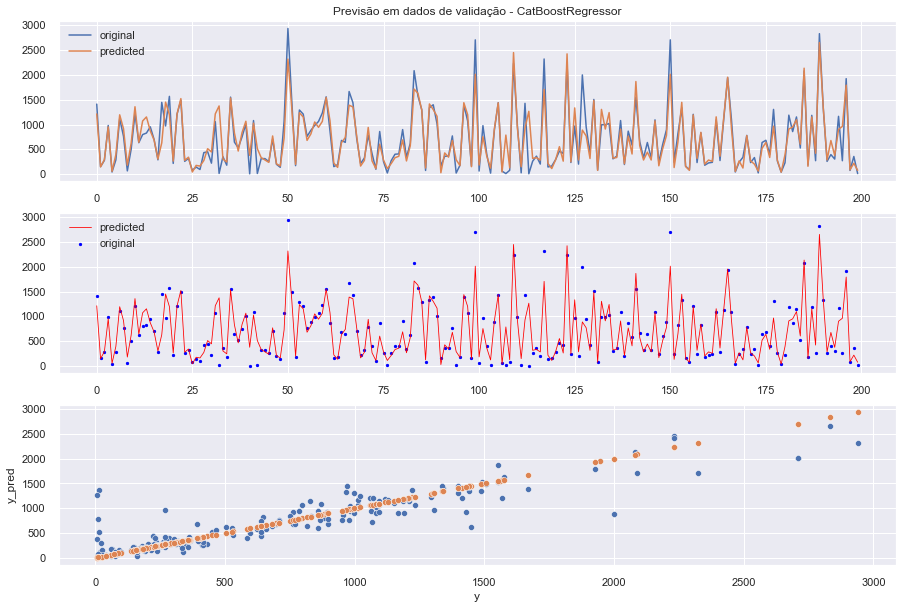

In [42]:
sample     = 200
model_name = 'CatBoostRegressor'
df         = df_preds[df_preds['model']==model_name].sample(sample)
x_ax       = range(len(df[:sample]))
y_nor      = df.y
y_pred     = df.y_pred


plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
plt.plot(x_ax, y_nor,  label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Previsão em dados de validação - {}".format(model_name))
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_ax, y_nor, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()

plt.subplot(3,1,3)


sns.scatterplot(x=df['y'], y=df['y_pred'],  ) # hue=df['y_pred']
sns.scatterplot(x=df['y'], y=df['y'])
plt.show()

plt.show()

del df, x_ax, y_nor, y_pred

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observando os gráficos acima, identificamos que o modelo tem dificuldade em prever os valores acima de 1200 e nas previsões temos valores negativos, sendo que nos dados de treino e validação não temos valores negativos.  

</div>

## 3.2. Variáveis Quantitativas

### 3.2.1. Outliers
Outliers são observações que estão distantes de outras observações. Eles podem ser devido a erros ou ser observações genuínas. Seja qual for o motivo, é importante identificá-los porque os modelos de aprendizado de máquina são sensíveis ao intervalo e à distribuição de valores, sendo assim, vamos aplicar algumas técnicas de identificação de outliers e fazer alguns tratamentos como: 
1. __Univariado__
    - Intervalo interquartil
    - Z-score

2. __Multivariado__    
    - Envelope Elíptico 
    - Isolation Forest 
    - Winsorizer <p>

    
**REFERÊNCIAS**: 
- https://leportella.com/pt-br/outliers-i/
- https://leportella.com/pt-br/outliers-ii/
- https://github.com/leportella/outlier-analysis
- https://github.com/brunobro/deteccao-remocao-de-outliers
- https://towardsdatascience.com/creating-custom-transformers-using-scikit-learn-5f9db7d7fdb5

#### 3.2.1.1. Idendificação dos Outliers

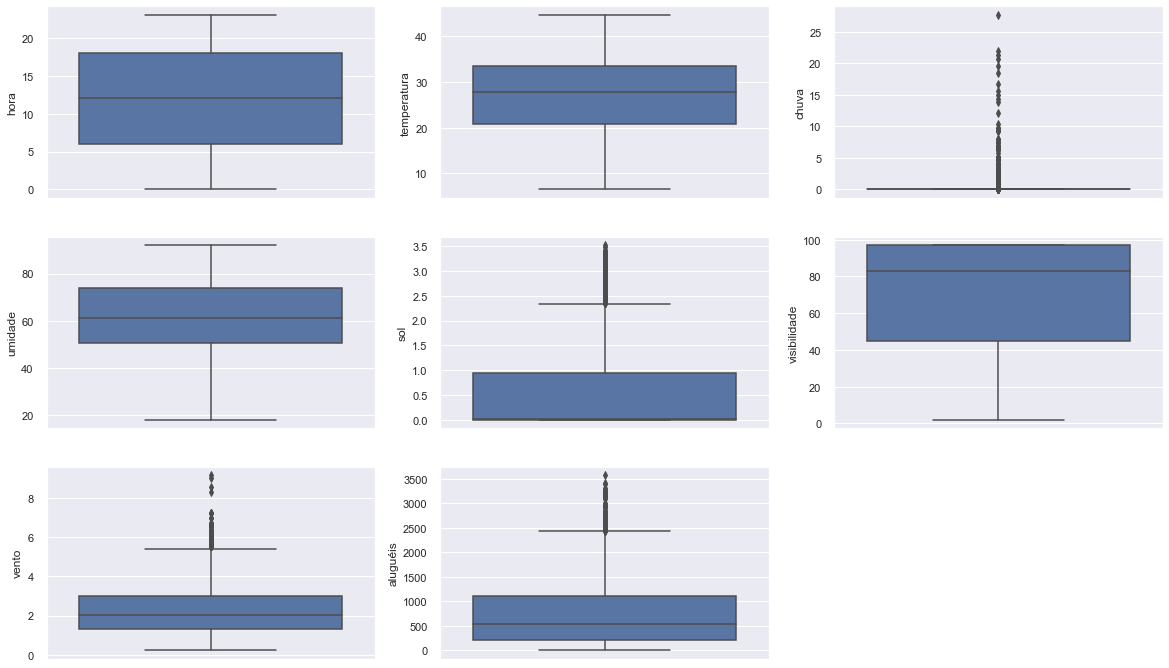

In [43]:
f, ax = plt.subplots(figsize=(20, 12))

feature_outliers = feature_float.copy()
feature_outliers.append(target)

df_outliers = df3_tr_03_one_hot[feature_outliers]

row = int(len(feature_outliers)/3 +1) 

for i, col in enumerate(feature_outliers): 
    plt.subplot(row,3,i+1)
    sns.boxplot(data=df_outliers,  y=col)

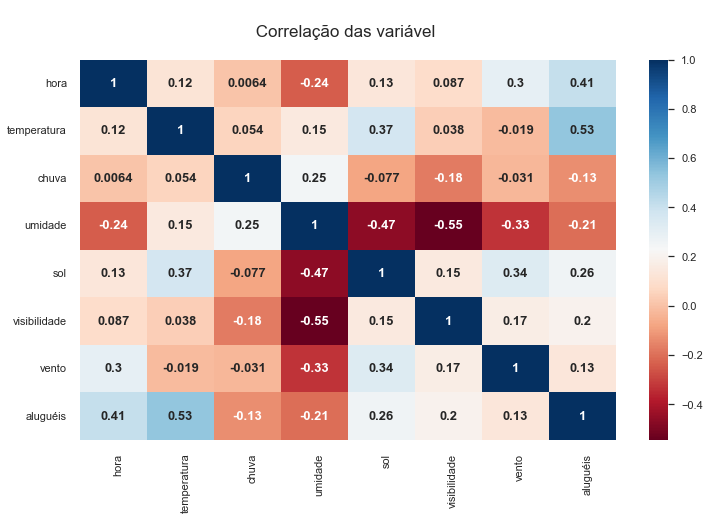

In [46]:
plt.figure(figsize=(12,7))
Ultil.graf_feature_corr(df_           = df_outliers, 
                        annot_      = True, 
                        threshold_  = .7, 
                        print_var_  = False, 
                        print_graf_ = True, 
                        mask_       = False);


<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temos quatro variáveis com outliers: **chuva, sol, vento e aluguéis**, neste primeiro momento vamos trabalhar apenas com as três primeiras variáveis, observamos que a correlação dessas variáveis são baixa com a variável alvo.
    
    
</div>

#### 3.2.1.1. Intervalo interquartil

In [47]:
def outlier_create_feature_check(df_train_, df_test_, cols_outlirs_=[], qt_inferior_=.25, 
                                 qt_superior_=.75, zero_outliers_=True, flg_ts_=True):
    
    col_oltlier = 'fe_outlier'

    if zero_outliers_:
        df_train_[col_oltlier] = 0 
        df_test_[col_oltlier]  = 0 

    for c in cols_outlirs_:
        
        percentil25 = df_train_[c].quantile(qt_inferior_)
        percentil75 = df_train_[c].quantile(qt_superior_)

        iqr= percentil75 - percentil25 

        limite_inferior = percentil25 - 1.5 * iqr
        limite_superior = percentil75 + 1.5 * iqr

        df_train_[col_oltlier][df_train_[c]>limite_superior] = -1
        df_train_[col_oltlier][df_train_[c]<limite_inferior] = -1

        if flg_ts_:
            df_test_[col_oltlier][df_test_[c]>limite_superior] = -1
            df_test_[col_oltlier][df_test_[c]<limite_inferior] = -1

        print('Com a variável {}'.format(c))
        print(df_train_[col_oltlier].value_counts())
        print()
        
    return df_train_, df_test_

In [48]:
df3_tr_01_mista_02       = df3_tr_01_mista.copy()
df3_ts_01_mista_02       = df3_ts_01_mista.copy()
df3_tr_02_ord_Encoder_02 = df3_tr_02_ord_Encoder.copy() 
df3_ts_02_ord_Encoder_02 = df3_ts_02_ord_Encoder.copy()
df3_tr_03_one_hot_02     = df3_tr_03_one_hot.copy()
df3_ts_03_one_hot_02     = df3_ts_03_one_hot.copy()

df21   = (df3_tr_01_mista_02, df3_ts_01_mista_02, 'df_mista', 1, 'dataset base')
df22   = (df3_tr_02_ord_Encoder_02, df3_ts_02_ord_Encoder_02, 'df_ord_Encoder', 2)
df23   = (df3_tr_03_one_hot_02, df3_ts_03_one_hot_02, 'df3_one_hot', 3) 
dfs_02 = [df21, df22, df23]

for i, df_ in enumerate(dfs_02):   
    df_tr = df_[0]
    df_ts = df_[1] 
    df_tr, df_ts = \
        outlier_create_feature_check(df_train_      = df_tr, 
                                     df_test_       = df_ts, 
                                     cols_outlirs_  = ['vento'], # 'sol', 'chuva',  vento
                                     qt_inferior_   = .25, 
                                     qt_superior_   = .75, 
                                     zero_outliers_ = True, 
                                     flg_ts_ = False
                                     )

Com a variável vento
 0    4424
-1      76
Name: fe_outlier, dtype: int64

Com a variável vento
 0    4424
-1      76
Name: fe_outlier, dtype: int64

Com a variável vento
 0    4424
-1      76
Name: fe_outlier, dtype: int64



In [49]:
%%time 
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds, model_best = model_fit(models_          = models,                     
                                 datasets_        = dfs_02,                      
                                 target_          = target, 
                                 path_            = path, 
                                 feature_drop_cor_= [], 
                                 scalers_         = scalers,                      
                                 seed_            = seed)

# The Best
# Model  : CatBoostRegressor
# Dataset: df3_train_fe_03_one_hot_encoder
# Scaler : StandardScaler()
# Score  : 236.29

Model: XGBRegressor -> df_mista
RMSE: 242.25 - MAE: 139.47 - MSE: 58686.34 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 58.61 => None

Model: XGBRegressor -> df_ord_Encoder
RMSE: 242.11 - MAE: 141.45 - MSE: 58618.24 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 100.04 => None

Model: XGBRegressor -> df3_one_hot
RMSE: 240.90 - MAE: 138.34 - MSE: 58034.39 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 61.39 => None

Model: LGBMRegressor -> df_mista
RMSE: 248.63 - MAE: 147.50 - MSE: 61818.39 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 198.71 => None

Model: LGBMRegressor -> df_ord_Encoder
RMSE: 248.84 - MAE: 147.67 - MSE: 61920.55 - MAPE: 1.69 - R2: 0.84 - TR RMSE: 208.89 => None

Model: LGBMRegressor -> df3_one_hot
RMSE: 247.65 - MAE: 145.71 - MSE: 61330.07 - MAPE: 1.68 - R2: 0.85 - TR RMSE: 214.93 => None

Model: CatBoostRegressor -> df_mista
RMSE: 243.51 - MAE: 145.31 - MSE: 59295.16 - MAPE: 1.43 - R2: 0.85 - TR RMSE: 90.67 => None

Model: CatBoostRegressor -> df_ord_Encoder
RMSE: 244.39 - MAE: 144.66 - MSE: 59728.50 - MAPE: 1

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Com a criação da variável que identifica os outliers com a técnica de **intervalo interquartil**, tivemos uma pequena melhoria no score da maioria dos modelos, entre as três variáveis: vento, sol, chuva, a variável que teve melhor desempenho foi a variável **vento**. 
    
</div>

#### 3.2.1.2. Z-score
Z-score  é uma medida relacionada a distância que um ponto está da média, em função do desvio padrão.


In [50]:
def feature_zscore(df_tr_, df_ts_, feature_):         
    md = np.mean(df_tr_[feature_])
    dp = np.std(df_tr_[feature_])    
    df_tr_['fe_outlier_zscore'] = (df_tr_[feature_]-md)/dp
    df_ts_['fe_outlier_zscore'] = (df_ts_[feature_]-md)/dp

In [51]:
%%time 

df3_tr_01_mista_03       = df3_tr_01_mista.copy()
df3_ts_01_mista_03       = df3_ts_01_mista.copy()
df3_tr_02_ord_Encoder_03 = df3_tr_02_ord_Encoder.copy() 
df3_ts_02_ord_Encoder_03 = df3_ts_02_ord_Encoder.copy()
df3_tr_03_one_hot_03     = df3_tr_03_one_hot.copy()
df3_ts_03_one_hot_03     = df3_ts_03_one_hot.copy()

df31   = (df3_tr_01_mista_03, df3_ts_01_mista_03, 'df3_tr_01_mista', 1, 'Z-score')
df32   = (df3_tr_02_ord_Encoder_03, df3_ts_02_ord_Encoder_03, 'df3_tr_02_ord_Encoder', 2)
df33   = (df3_tr_03_one_hot_03, df3_ts_03_one_hot_03, 'df3_tr_03_one_hot', 3)
dfs_03 = [df31, df32, df33]

for df_ in dfs_03: 
    feature_zscore(df_[0], df_[1], 'sol') # 'sol', 'chuva',  vento
    
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds, model = model_fit(models_          = models,                     
                            datasets_        = dfs_03,                      
                            target_          = target, 
                            path_            = path, 
                            feature_drop_cor_= [], 
                            scalers_         = scalers,                      
                            seed_            = seed)

# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 235.00

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 241.72 - MAE: 139.01 - MSE: 58427.56 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 60.60 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 242.15 - MAE: 142.01 - MSE: 58636.55 - MAPE: 1.53 - R2: 0.85 - TR RMSE: 79.97 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 241.89 - MAE: 138.97 - MSE: 58511.62 - MAPE: 1.56 - R2: 0.85 - TR RMSE: 61.94 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 249.21 - MAE: 148.84 - MSE: 62107.12 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 217.19 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 250.18 - MAE: 148.65 - MSE: 62591.79 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 211.69 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 248.26 - MAE: 146.80 - MSE: 61632.67 - MAPE: 1.69 - R2: 0.84 - TR RMSE: 215.92 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 241.91 - MAE: 142.11 - MSE: 58521.45 - MAPE: 1.44 - R2: 0.85 - TR RMSE: 89.37 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encoder

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos uma melhoria. 
    
</div>

#### 3.2.1.3. Envelope Elíptico
É uma técnica relacionada ao Determinante de Covariância Mínima, que é um estimador altamente robusto para estimação de dispersão multivariada.

* Supõe uma distribuição Gaussiana

Em síntese, emprega a ideia de uma hiperesfera (hiperelipse) no espaço de entrada, com uma distribuição Gaussiana. Aquelas amostras que estão fora desta hiperesfera são consideradas Outliers.

Referência: https://arxiv.org/pdf/1709.07045.pdf


In [52]:
%%time 

cols_feature = ['vento'] # 'chuva', 'sol', 'vento'

df_outliers_tr = pd.DataFrame(df3_tr_03_one_hot[cols_feature] )
df_outliers_ts = pd.DataFrame(df3_ts_03_one_hot[cols_feature])

model_e_eliptico = EllipticEnvelope(contamination=0.1)
model_e_eliptico.fit(df_outliers_tr)

out_EE_tr = model_e_eliptico.predict(df_outliers_tr)
out_EE_ts = model_e_eliptico.predict(df_outliers_ts)

df3_tr_01_mista_04       = df3_tr_01_mista.copy()
df3_ts_01_mista_04       = df3_ts_01_mista.copy()
df3_tr_02_ord_Encoder_04 = df3_tr_02_ord_Encoder.copy() 
df3_ts_02_ord_Encoder_04 = df3_ts_02_ord_Encoder.copy()
df3_tr_03_one_hot_04     = df3_tr_03_one_hot.copy()
df3_ts_03_one_hot_04     = df3_ts_03_one_hot.copy()

df41 = (df3_tr_01_mista_04, df3_ts_01_mista_04, 'df3_tr_01_mista', 1, 'Envelope Elíptico')
df42 = (df3_tr_02_ord_Encoder_04, df3_ts_02_ord_Encoder_04, 'df3_tr_02_ord_Encoder', 2)
df43 = (df3_tr_03_one_hot_04, df3_ts_03_one_hot_04, 'df3_tr_03_one_hot', 3) 

dfs_04 = [df41, df42, df43]

for df_ in dfs_04:
    df_[0]['fe_outlier_env_eliptico'] = out_EE_tr
    df_[1]['fe_outlier_env_eliptico'] = out_EE_ts
    
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds = model_fit(models_          = models,                     
                     datasets_        = dfs_04,                      
                     target_          = target, 
                     path_            = path, 
                     feature_drop_cor_= [], 
                     scalers_         = scalers,                      
                     seed_            = seed)
   
# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 235.00

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 242.20 - MAE: 139.68 - MSE: 58661.55 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 65.60 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 242.11 - MAE: 141.45 - MSE: 58615.50 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 74.89 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 242.03 - MAE: 138.81 - MSE: 58576.25 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 59.45 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 248.98 - MAE: 147.58 - MSE: 61991.29 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 199.18 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 249.55 - MAE: 147.90 - MSE: 62277.64 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 212.49 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 248.72 - MAE: 146.64 - MSE: 61859.49 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 216.31 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 243.13 - MAE: 144.77 - MSE: 59112.05 - MAPE: 1.43 - R2: 0.85 - TR RMSE: 93.18 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encoder

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos uma melhoria. 
    
</div>

#### 3.2.1.4. Isolation Forest

In [53]:
def outlier_IsolationForest(df_tr_, df_ts_, feature_):
    # https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/
    #Retorna -1 se a amostra é Outlier e 1 caso contrário

    X_tr = df_tr_[feature_].values.reshape(-1, 1)
    X_ts = df_ts_[feature_].values.reshape(-1, 1)

    model_if = IsolationForest( n_estimators  = 1000,                                 
                                contamination = float(.15),
                                n_jobs        = -1, 
                                random_state  = seed, 
                                verbose       = 0)
    
    model_if.fit(X_tr)

    out_IF_tr = model_if.predict(X_tr)
    out_IF_ts = model_if.predict(X_ts)

    return out_IF_tr , out_IF_ts

In [54]:
%%time 

df3_tr_01_mista_05       = df3_tr_01_mista.copy()
df3_ts_01_mista_05       = df3_ts_01_mista.copy()
df3_tr_02_ord_Encoder_05 = df3_tr_02_ord_Encoder.copy() 
df3_ts_02_ord_Encoder_05 = df3_ts_02_ord_Encoder.copy()
df3_tr_03_one_hot_05     = df3_tr_03_one_hot.copy()
df3_ts_03_one_hot_05     = df3_ts_03_one_hot.copy()

out_IF_tr , out_IF_ts = outlier_IsolationForest(df3_tr_01_mista_05, 
                                                df3_ts_01_mista_05,
                                                'sol')  # chuva, sol, vento

df51   = (df3_tr_01_mista_05, df3_ts_01_mista_05, 'df3_tr_01_mista', 1, 'Envelope Elíptico')
df52   = (df3_tr_02_ord_Encoder_05, df3_ts_02_ord_Encoder_05, 'df3_tr_02_ord_Encoder', 2)
df53   = (df3_tr_03_one_hot_05, df3_ts_03_one_hot_05, 'df3_tr_03_one_hot', 3) 
dfs_05 = [df51, df52, df53]

for df_ in dfs_05:
    df_[0]['fe_outlier_iso_forest'] = out_IF_tr
    df_[1]['fe_outlier_iso_forest'] = out_IF_ts
    
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds = model_fit(models_          = models,                     
                     datasets_        = dfs_05,                      
                     target_          = target, 
                     path_            = path, 
                     feature_drop_cor_= [], 
                     scalers_         = scalers,                      
                     seed_            = seed)
   
# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 235.00

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 242.78 - MAE: 139.78 - MSE: 58942.79 - MAPE: 1.53 - R2: 0.85 - TR RMSE: 61.90 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 241.49 - MAE: 141.17 - MSE: 58316.41 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 65.79 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 241.67 - MAE: 138.46 - MSE: 58403.59 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 61.03 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 249.95 - MAE: 148.85 - MSE: 62477.43 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 217.50 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 248.91 - MAE: 147.38 - MSE: 61955.04 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 206.80 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 248.91 - MAE: 146.65 - MSE: 61955.27 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 217.99 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 243.00 - MAE: 143.88 - MSE: 59050.65 - MAPE: 1.46 - R2: 0.85 - TR RMSE: 136.60 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encode

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Não tivemos melhoria, a melhor técnica com as três variáveis foi **Intervalo interquartil** com score de 235.12 utilizando o **GradientBoostingRegressor** no dataset **df3_train_fe_03_one_hot_encoder**.
 
Nos próximos passos vamos utilizar  o conjunto de datasets da variável **dfs_02**, que teve o melhor desempenho até agora. 
    
</div>

In [57]:
dfs_02[2][0].head()

,hora,temperatura,chuva,umidade,sol,visibilidade,vento,aluguéis,fe_dia_sábado,fe_dia_sexta,fe_dia_segunda,fe_dia_quarta,fe_dia_domingo,fe_dia_quinta,fe_dia_terça,fe_estação_verão,fe_estação_primavera,fe_estação_outono,fe_estação_inverno,fe_feriado_não,fe_feriado_sim,fe_outlier
0,16,39.4,0.0,61.1,2.19,92.0,3.49,1318,0,0,0,0,0,1,0,0,0,0,1,1,0,0
1,21,22.2,0.0,63.3,0.00,32.0,2.89,686,0,0,0,0,1,0,0,0,0,1,0,1,0,0
2,16,40.5,0.0,52.8,2.51,93.0,3.97,831,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,7,25.6,0.0,70.9,0.00,97.0,1.09,15,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,9,39.9,0.0,58.1,1.69,62.0,1.09,865,0,0,0,1,0,0,0,0,0,0,1,1,0,0


### 3.3.2. Feature Math

In [56]:
%%time 

def create_feature_Statistic(df_, feature_):
    df_['fe_mean'] = df_[feature_].mean(axis=1) #/ 1000    
    #df_['hora']    = df_['hora'] / 24
    
df3_tr_01_mista_06       = dfs_02[0][0].copy()
df3_ts_01_mista_06       = dfs_02[0][1].copy()
df3_tr_02_ord_Encoder_06 = dfs_02[1][0].copy() 
df3_ts_02_ord_Encoder_06 = dfs_02[1][1].copy()
df3_tr_03_one_hot_06     = dfs_02[2][0].copy()
df3_ts_03_one_hot_06     = dfs_02[2][1].copy()

df61   = (df3_tr_01_mista_06, df3_ts_01_mista_06, 'df3_tr_01_mista', 1, 'Isolation Forest')
df62   = (df3_tr_02_ord_Encoder_06, df3_ts_02_ord_Encoder_06, 'df3_tr_02_ord_Encoder', 2)
df63   = (df3_tr_03_one_hot_06, df3_ts_03_one_hot_06, 'df3_tr_03_one_hot', 3) 
dfs_06 = [df61, df62, df63]

feature_statistic = ['temperatura', 'chuva', 'umidade', 'vento', 'sol', 'visibilidade']
 
for df_ in dfs_06:
    create_feature_Statistic(df_[0], feature_statistic)
    create_feature_Statistic(df_[1], feature_statistic)
        
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds, model = model_fit(models_          = models,                     
                            datasets_        = dfs_06,                      
                            target_          = target, 
                            path_            = path, 
                            feature_drop_cor_= [], 
                            scalers_         = scalers,                                  
                            seed_            = seed)

# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 235.00 234.24 233.50

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 237.66 - MAE: 138.77 - MSE: 56482.07 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 56.76 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 237.05 - MAE: 138.33 - MSE: 56193.53 - MAPE: 1.45 - R2: 0.86 - TR RMSE: 60.69 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 238.10 - MAE: 137.41 - MSE: 56689.73 - MAPE: 1.47 - R2: 0.86 - TR RMSE: 56.10 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 243.36 - MAE: 145.12 - MSE: 59226.33 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 167.51 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 245.33 - MAE: 146.22 - MSE: 60187.72 - MAPE: 1.56 - R2: 0.85 - TR RMSE: 176.86 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 242.71 - MAE: 142.83 - MSE: 58906.36 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 166.66 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 235.03 - MAE: 139.62 - MSE: 55238.33 - MAPE: 1.30 - R2: 0.86 - TR RMSE: 85.23 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encoder

## 3.3. PCA

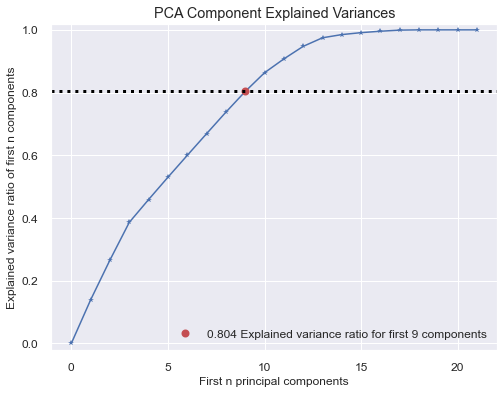

In [58]:
df_pca_tr   = dfs_02[2][0].drop(target, axis=1)
df_pca_ts   = dfs_02[2][1]
feature_pca = df_pca_tr.columns.to_list()

scaler = MinMaxScaler() 
scaler.fit(df_pca_tr)

df_pca_tr = pd.DataFrame(scaler.fit_transform(df_pca_tr), columns=feature_pca)
df_pca_ts = pd.DataFrame(scaler.fit_transform(df_pca_ts), columns=feature_pca)

pca             = PCA(random_state=12359)
df3_4_train_pca = pca.fit_transform(df_pca_tr)

skplt.decomposition.plot_pca_component_variance(pca, figsize=(8,6));
# .783

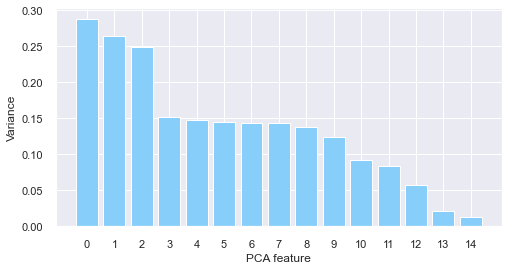

In [59]:
features = range(pca.n_components_)

plt.figure(figsize=(8,4))
plt.bar(features[:15], pca.explained_variance_[:15], color='lightskyblue')
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features[:15])
plt.show()

In [60]:
n_components  = 3
pca           = PCA(n_components=n_components, random_state=123)
pca_feats     = [f'fe_pca_{i}' for i in range(n_components)]

df_pca_tr[pca_feats] = pca.fit_transform(df_pca_tr)
df_pca_ts[pca_feats] = pca.transform(df_pca_ts)

In [61]:
df_pca_tr.head()

,hora,temperatura,chuva,umidade,sol,visibilidade,vento,fe_dia_sábado,fe_dia_sexta,fe_dia_segunda,fe_dia_quarta,fe_dia_domingo,fe_dia_quinta,fe_dia_terça,fe_estação_verão,fe_estação_primavera,fe_estação_outono,fe_estação_inverno,fe_feriado_não,fe_feriado_sim,fe_outlier,fe_pca_0,fe_pca_1,fe_pca_2
0,0.695652,0.863517,0.0,0.581867,0.622159,0.947368,0.364865,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.886155,-0.194079,-0.388449
1,0.913043,0.412073,0.0,0.611637,0.000000,0.315789,0.297297,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,-0.121129,0.901290,0.175756
2,0.695652,0.892388,0.0,0.469553,0.713068,0.957895,0.418919,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.847039,-0.136356,-0.340440
3,0.304348,0.501312,0.0,0.714479,0.000000,1.000000,0.094595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,-0.173639,-0.537690,0.754994
4,0.391304,0.876640,0.0,0.541272,0.480114,0.631579,0.094595,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.813269,-0.075589,-0.341019


## 3.4. Clustering 

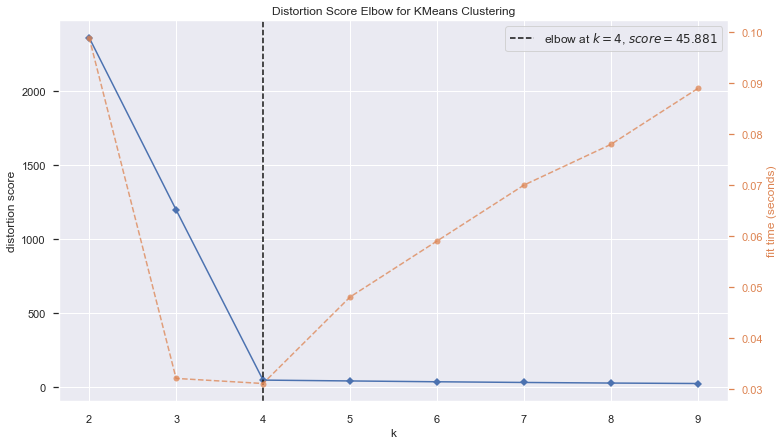

In [62]:

plt.figure(figsize=(12, 7))
visualizer_1 = KElbowVisualizer(KMeans(random_state=12359), k=(2,10))
visualizer_1.fit(df_pca_tr[pca_feats])
visualizer_1.poof();

In [63]:
model_kmeans = KMeans(n_clusters=4, random_state=12359)
model_kmeans.fit(df_pca_tr[pca_feats]);

clusters_train = model_kmeans.predict(df_pca_tr[pca_feats])
clusters_test  = model_kmeans.predict(df_pca_ts[pca_feats])

In [64]:
%%time 

def create_feature_Statistic(df_, feature_):
    df_['fe_mean'] = df_[feature_].mean(axis=1) #/ 1000    
    
    
df3_tr_01_mista_07       = dfs_02[0][0].copy()
df3_ts_01_mista_07       = dfs_02[0][1].copy()
df3_tr_02_ord_Encoder_07 = dfs_02[1][0].copy() 
df3_ts_02_ord_Encoder_07 = dfs_02[1][1].copy()
df3_tr_03_one_hot_07     = dfs_02[2][0].copy()
df3_ts_03_one_hot_07     = dfs_02[2][1].copy()

df71   = (df3_tr_01_mista_07, df3_ts_01_mista_07, 'df3_tr_01_mista', 1, 'Isolation Forest')
df72   = (df3_tr_02_ord_Encoder_07, df3_ts_02_ord_Encoder_07, 'df3_tr_02_ord_Encoder', 2)
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df3_tr_03_one_hot', 3) 
dfs_07 = [df71, df72, df73]

feature_statistic = ['temperatura', 'chuva', 'umidade', 'vento', 'sol', 'visibilidade']
 
for df_ in dfs_07:
    create_feature_Statistic(df_[0], feature_statistic)
    create_feature_Statistic(df_[1], feature_statistic)
    df_[0]['fe_cluster'] = clusters_train
    df_[1]['fe_cluster'] = clusters_test
    
scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds, model = model_fit(models_          = models,                     
                            datasets_        = dfs_07,                      
                            target_          = target, 
                            path_            = path, 
                            feature_drop_cor_= [], 
                            scalers_         = scalers,                                  
                            seed_            = seed)

# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 233.48

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 238.77 - MAE: 139.41 - MSE: 57008.96 - MAPE: 1.48 - R2: 0.86 - TR RMSE: 102.47 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 238.00 - MAE: 138.18 - MSE: 56646.36 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 56.37 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 235.44 - MAE: 136.42 - MSE: 55432.42 - MAPE: 1.41 - R2: 0.86 - TR RMSE: 55.65 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 243.66 - MAE: 144.08 - MSE: 59372.60 - MAPE: 1.57 - R2: 0.85 - TR RMSE: 176.02 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 244.89 - MAE: 145.81 - MSE: 59969.55 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 170.15 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 244.94 - MAE: 143.65 - MSE: 59993.85 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 195.66 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 238.13 - MAE: 141.30 - MSE: 56703.80 - MAPE: 1.31 - R2: 0.86 - TR RMSE: 83.52 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encode

In [ ]:
Model: XGBRegressor -> df3_tr_01_mista
  RMSE: 242.62 - MAE: 140.10 - MSE: 58864.09 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 88.54 => None
  RMSE: 240.57 - MAE: 140.04 - MSE: 57871.57 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 61.25 => None
* RMSE: 238.92 - MAE: 136.85 - MSE: 57082.50 - MAPE: 1.51 - R2: 0.86 - TR RMSE: 58.47 => None

  RMSE: 242.25 - MAE: 139.47 - MSE: 58686.34 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 58.61 => None
  RMSE: 242.11 - MAE: 141.45 - MSE: 58618.24 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 100.04 => None
* RMSE: 240.90 - MAE: 138.34 - MSE: 58034.39 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 61.39 => None
                        
* RMSE: 241.72 - MAE: 139.01 - MSE: 58427.56 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 60.60 => None
  RMSE: 242.15 - MAE: 142.01 - MSE: 58636.55 - MAPE: 1.53 - R2: 0.85 - TR RMSE: 79.97 => None
  RMSE: 241.89 - MAE: 138.97 - MSE: 58511.62 - MAPE: 1.56 - R2: 0.85 - TR RMSE: 61.94 => None

  RMSE: 242.20 - MAE: 139.68 - MSE: 58661.55 - MAPE: 1.54 - R2: 0.85 - TR RMSE: 65.60 => None
  RMSE: 242.11 - MAE: 141.45 - MSE: 58615.50 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 74.89 => None
* RMSE: 242.03 - MAE: 138.81 - MSE: 58576.25 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 59.45 => None

  RMSE: 242.78 - MAE: 139.78 - MSE: 58942.79 - MAPE: 1.53 - R2: 0.85 - TR RMSE: 61.90 => None
* RMSE: 241.49 - MAE: 141.17 - MSE: 58316.41 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 65.79 => None
  RMSE: 241.67 - MAE: 138.46 - MSE: 58403.59 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 61.03 => None

  RMSE: 237.66 - MAE: 138.77 - MSE: 56482.07 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 56.76 => None
* RMSE: 237.05 - MAE: 138.33 - MSE: 56193.53 - MAPE: 1.45 - R2: 0.86 - TR RMSE: 60.69 => None
  RMSE: 238.10 - MAE: 137.41 - MSE: 56689.73 - MAPE: 1.47 - R2: 0.86 - TR RMSE: 56.10 => None

  RMSE: 238.77 - MAE: 139.41 - MSE: 57008.96 - MAPE: 1.48 - R2: 0.86 - TR RMSE: 102.47 => None
  RMSE: 238.00 - MAE: 138.18 - MSE: 56646.36 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 56.37 => None
* RMSE: 235.44 - MAE: 136.42 - MSE: 55432.42 - MAPE: 1.41 - R2: 0.86 - TR RMSE: 55.65 => None

ok 

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Model: LGBMRegressor -> df3_tr_01_mista
* RMSE: 248.51 - MAE: 147.48 - MSE: 61756.55 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 193.38 => None
  RMSE: 248.94 - MAE: 148.26 - MSE: 61970.16 - MAPE: 1.65 - R2: 0.84 - TR RMSE: 197.68 => None
  RMSE: 249.79 - MAE: 146.90 - MSE: 62395.38 - MAPE: 1.66 - R2: 0.84 - TR RMSE: 214.58 => None

  RMSE: 248.63 - MAE: 147.50 - MSE: 61818.39 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 198.71 => None
  RMSE: 248.84 - MAE: 147.67 - MSE: 61920.55 - MAPE: 1.69 - R2: 0.84 - TR RMSE: 208.89 => None
* RMSE: 247.65 - MAE: 145.71 - MSE: 61330.07 - MAPE: 1.68 - R2: 0.85 - TR RMSE: 214.93 => None

  RMSE: 249.21 - MAE: 148.84 - MSE: 62107.12 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 217.19 => None
  RMSE: 250.18 - MAE: 148.65 - MSE: 62591.79 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 211.69 => None
* RMSE: 248.26 - MAE: 146.80 - MSE: 61632.67 - MAPE: 1.69 - R2: 0.84 - TR RMSE: 215.92 => None

  RMSE: 248.98 - MAE: 147.58 - MSE: 61991.29 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 199.18 => None
  RMSE: 249.55 - MAE: 147.90 - MSE: 62277.64 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 212.49 => None
* RMSE: 248.72 - MAE: 146.64 - MSE: 61859.49 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 216.31 => None

  RMSE: 249.95 - MAE: 148.85 - MSE: 62477.43 - MAPE: 1.68 - R2: 0.84 - TR RMSE: 217.50 => None  
  RMSE: 248.91 - MAE: 147.38 - MSE: 61955.04 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 206.80 => None
* RMSE: 248.91 - MAE: 146.65 - MSE: 61955.27 - MAPE: 1.67 - R2: 0.84 - TR RMSE: 217.99 => None

  RMSE: 243.36 - MAE: 145.12 - MSE: 59226.33 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 167.51 => None
  RMSE: 245.33 - MAE: 146.22 - MSE: 60187.72 - MAPE: 1.56 - R2: 0.85 - TR RMSE: 176.86 => None
* RMSE: 242.71 - MAE: 142.83 - MSE: 58906.36 - MAPE: 1.52 - R2: 0.85 - TR RMSE: 166.66 => None

* RMSE: 243.66 - MAE: 144.08 - MSE: 59372.60 - MAPE: 1.57 - R2: 0.85 - TR RMSE: 176.02 => None
  RMSE: 244.89 - MAE: 145.81 - MSE: 59969.55 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 170.15 => None
  RMSE: 244.94 - MAE: 143.65 - MSE: 59993.85 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 195.66 => None
                        
df63   = (df3_tr_03_one_hot_06, df3_ts_03_one_hot_06, 'df3_tr_03_one_hot', 3) 
                        
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Model: CatBoostRegressor -> df3_tr_01_mista
  RMSE: 240.24 - MAE: 141.82 - MSE: 57716.52 - MAPE: 1.39 - R2: 0.85 - TR RMSE: 98.85 => None
  RMSE: 246.36 - MAE: 146.00 - MSE: 60695.31 - MAPE: 1.43 - R2: 0.85 - TR RMSE: 123.38 => None
* RMSE: 235.93 - MAE: 140.13 - MSE: 55663.33 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 86.49 => None

  RMSE: 243.51 - MAE: 145.31 - MSE: 59295.16 - MAPE: 1.43 - R2: 0.85 - TR RMSE: 90.67 => None
  RMSE: 244.39 - MAE: 144.66 - MSE: 59728.50 - MAPE: 1.51 - R2: 0.85 - TR RMSE: 176.27 => None
* RMSE: 235.15 - MAE: 138.54 - MSE: 55296.89 - MAPE: 1.43 - R2: 0.86 - TR RMSE: 95.87 => None

  RMSE: 241.91 - MAE: 142.11 - MSE: 58521.45 - MAPE: 1.44 - R2: 0.85 - TR RMSE: 89.37 => None
  RMSE: 246.39 - MAE: 145.03 - MSE: 60707.93 - MAPE: 1.47 - R2: 0.85 - TR RMSE: 103.37 => None
* RMSE: 235.87 - MAE: 137.78 - MSE: 55634.42 - MAPE: 1.42 - R2: 0.86 - TR RMSE: 104.10 => None

  RMSE: 243.13 - MAE: 144.77 - MSE: 59112.05 - MAPE: 1.43 - R2: 0.85 - TR RMSE: 93.18 => None
  RMSE: 244.58 - MAE: 146.07 - MSE: 59819.96 - MAPE: 1.47 - R2: 0.85 - TR RMSE: 150.44 => None
* RMSE: 234.93 - MAE: 138.43 - MSE: 55191.45 - MAPE: 1.39 - R2: 0.86 - TR RMSE: 84.79 => None

  RMSE: 243.00 - MAE: 143.88 - MSE: 59050.65 - MAPE: 1.46 - R2: 0.85 - TR RMSE: 136.60 => None
  RMSE: 244.12 - MAE: 143.57 - MSE: 59592.49 - MAPE: 1.48 - R2: 0.85 - TR RMSE: 141.87 => None
* RMSE: 235.37 - MAE: 138.21 - MSE: 55401.16 - MAPE: 1.40 - R2: 0.86 - TR RMSE: 105.28 => None

  RMSE: 235.03 - MAE: 139.62 - MSE: 55238.33 - MAPE: 1.30 - R2: 0.86 - TR RMSE: 85.23 => None
  RMSE: 237.71 - MAE: 140.55 - MSE: 56507.48 - MAPE: 1.28 - R2: 0.86 - TR RMSE: 86.69 => None
* RMSE: 232.80 - MAE: 137.42 - MSE: 54197.84 - MAPE: 1.26 - R2: 0.86 - TR RMSE: 78.28 => None

  RMSE: 238.13 - MAE: 141.30 - MSE: 56703.80 - MAPE: 1.31 - R2: 0.86 - TR RMSE: 83.52 => None
  RMSE: 236.48 - MAE: 141.16 - MSE: 55923.40 - MAPE: 1.32 - R2: 0.86 - TR RMSE: 82.23 => None
* RMSE: 231.38 - MAE: 137.73 - MSE: 53537.12 - MAPE: 1.28 - R2: 0.87 - TR RMSE: 98.47 => None
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df3_tr_03_one_hot', 3) 
                        
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Model: GradientBoostingRegressor -> df3_tr_01_mista
  RMSE: 239.08 - MAE: 139.45 - MSE: 57161.07 - MAPE: 1.54 - R2: 0.86 - TR RMSE: 143.16 => None
  RMSE: 242.76 - MAE: 140.98 - MSE: 58932.04 - MAPE: 1.67 - R2: 0.85 - TR RMSE: 144.38 => None
* RMSE: 238.03 - MAE: 138.05 - MSE: 56659.60 - MAPE: 1.53 - R2: 0.86 - TR RMSE: 146.66 => None
                        
  RMSE: 242.51 - MAE: 140.24 - MSE: 58811.01 - MAPE: 1.59 - R2: 0.85 - TR RMSE: 143.22 => None
  RMSE: 241.16 - MAE: 140.34 - MSE: 58160.27 - MAPE: 1.60 - R2: 0.85 - TR RMSE: 141.03 => None
* RMSE: 234.72 - MAE: 136.83 - MSE: 55094.61 - MAPE: 1.54 - R2: 0.86 - TR RMSE: 145.81 => None
    
* RMSE: 238.74 - MAE: 138.66 - MSE: 56995.17 - MAPE: 1.57 - R2: 0.86 - TR RMSE: 143.03 => None
  RMSE: 242.43 - MAE: 140.35 - MSE: 58774.21 - MAPE: 1.63 - R2: 0.85 - TR RMSE: 143.52 => None
  RMSE: 241.68 - MAE: 139.77 - MSE: 58409.57 - MAPE: 1.60 - R2: 0.85 - TR RMSE: 143.58 => None
         
  RMSE: 241.29 - MAE: 143.29 - MSE: 58219.54 - MAPE: 1.56 - R2: 0.85 - TR RMSE: 141.69 => None
  RMSE: 240.83 - MAE: 139.64 - MSE: 58000.98 - MAPE: 1.64 - R2: 0.85 - TR RMSE: 144.11 => None
* RMSE: 236.44 - MAE: 138.27 - MSE: 55904.70 - MAPE: 1.52 - R2: 0.86 - TR RMSE: 145.86 => None
         
  RMSE: 241.27 - MAE: 140.61 - MSE: 58212.39 - MAPE: 1.58 - R2: 0.85 - TR RMSE: 143.16 => None
  RMSE: 240.93 - MAE: 140.41 - MSE: 58046.95 - MAPE: 1.63 - R2: 0.85 - TR RMSE: 143.31 => None
* RMSE: 237.89 - MAE: 137.04 - MSE: 56590.51 - MAPE: 1.57 - R2: 0.86 - TR RMSE: 146.12 => None
     
  RMSE: 240.13 - MAE: 140.34 - MSE: 57664.12 - MAPE: 1.51 - R2: 0.85 - TR RMSE: 135.71 => None
  RMSE: 240.59 - MAE: 138.69 - MSE: 57881.59 - MAPE: 1.51 - R2: 0.85 - TR RMSE: 142.54 => None
* RMSE: 233.96 - MAE: 136.28 - MSE: 54736.34 - MAPE: 1.46 - R2: 0.86 - TR RMSE: 142.68 => None

  RMSE: 239.25 - MAE: 140.44 - MSE: 57241.89 - MAPE: 1.48 - R2: 0.86 - TR RMSE: 133.82 => None
  RMSE: 237.39 - MAE: 138.99 - MSE: 56352.55 - MAPE: 1.48 - R2: 0.86 - TR RMSE: 138.55 => None
* RMSE: 233.93 - MAE: 138.00 - MSE: 54724.62 - MAPE: 1.45 - R2: 0.86 - TR RMSE: 139.81 => None

In [65]:
%%time 

# xgb 
# RMSE: 235.44
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df3_tr_03_one_hot', 3) 

# LGBMRegressor
df63   = (df3_tr_03_one_hot_06, df3_ts_03_one_hot_06, 'df3_tr_03_one_hot', 3) 

# CatBoostRegressor 
# RMSE: 231.38
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df3_tr_03_one_hot', 3) 

# GradientBoostingRegressor 
# RMSE: 233.93
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df3_tr_03_one_hot', 3)


dfs_08 = [df63, df73]

scalers = [None]

models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]

df_preds, model = model_fit(models_          = models,                     
                            datasets_        = dfs_07,                      
                            target_          = target, 
                            path_            = path, 
                            feature_drop_cor_= [], 
                            scalers_         = scalers,                                  
                            seed_            = seed)

Model: XGBRegressor -> df3_tr_01_mista
RMSE: 238.77 - MAE: 139.41 - MSE: 57008.96 - MAPE: 1.48 - R2: 0.86 - TR RMSE: 102.47 => None

Model: XGBRegressor -> df3_tr_02_ord_Encoder
RMSE: 238.00 - MAE: 138.18 - MSE: 56646.36 - MAPE: 1.44 - R2: 0.86 - TR RMSE: 56.37 => None

Model: XGBRegressor -> df3_tr_03_one_hot
RMSE: 235.44 - MAE: 136.42 - MSE: 55432.42 - MAPE: 1.41 - R2: 0.86 - TR RMSE: 55.65 => None

Model: LGBMRegressor -> df3_tr_01_mista
RMSE: 243.66 - MAE: 144.08 - MSE: 59372.60 - MAPE: 1.57 - R2: 0.85 - TR RMSE: 176.02 => None

Model: LGBMRegressor -> df3_tr_02_ord_Encoder
RMSE: 244.89 - MAE: 145.81 - MSE: 59969.55 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 170.15 => None

Model: LGBMRegressor -> df3_tr_03_one_hot
RMSE: 244.94 - MAE: 143.65 - MSE: 59993.85 - MAPE: 1.55 - R2: 0.85 - TR RMSE: 195.66 => None

Model: CatBoostRegressor -> df3_tr_01_mista
RMSE: 238.13 - MAE: 141.30 - MSE: 56703.80 - MAPE: 1.31 - R2: 0.86 - TR RMSE: 83.52 => None

Model: CatBoostRegressor -> df3_tr_02_ord_Encode

In [ ]:
files = ['catb_2_231.38_df3_tr_03_one_hot_none.csv', 'gbr_2_233.93_df3_tr_03_one_hot_none.csv', 
         'lgb_0_243.66_df3_tr_01_mista_none.csv', 'xgb_2_235.44_df3_tr_03_one_hot_none.csv'
        ]

df  = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(path + 'Data/Submission/'+ file)
    df = pd.concat([df, df1], axis=1)

pd.DataFrame(df.mean(axis=1).astype(np.int64), columns=['aluguéis']).to_csv(path + 'Data/Submission/sub_09.csv', index=False)

In [ ]:
0        951.000000
1        433.000000
2        192.666667
3        464.666667
4       2205.000000
           ...     
2995     415.333333
2996     142.666667
2997     270.333333
2998     236.666667
2999     114.000000

In [ ]:
X_train_s   = dfs_06[2][0].drop(target, axis=1)
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_s)

In [ ]:
shap.summary_plot(shap_values, X_train_s, plot_type="bar", max_display=100)

In [ ]:
shap.summary_plot(shap_values, X_train_s, max_display=100)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Com a criação da variável cluster, tivemos uma melhora no score e a variável se posicionou entre as 10. 
    
</div>

## 3.5. Variável Alvo

##### 3.2.1.5.1. Análise 

In [ ]:
perc_inferior  = dfs_06[2][0][target].quantile(.01)
perc_superior  = dfs_06[2][0][target].quantile(.99)
filtro_outlier = (df3_train[target]>perc_inferior) & (df3_train[target]<perc_superior)

vlr_inferior    = df3_train[df3_train[target]< perc_inferior][target]
vlr_superior    = df3_train[df3_train[target]>=perc_superior][target]
vlr_sem_outlier = df3_train[filtro_outlier][target]

print('Valor inferior: {:2.2f} -> Quantidade: {}'.format(perc_inferior, len(vlr_inferior)))
print('Valor superior: {:2.2f} -> Quantidade: {}'.format(perc_superior, len(vlr_superior)))
print()
print('Dataset Normal')
print(df3_train[target].describe())
print()
print('Sem Outliers')
print(vlr_sem_outlier.describe())

In [ ]:
power  = PowerTransformer(method='box-cox') # 
y_ori  = dfs_02[2][0][target]  
y_log  = np.log1p(y_ori)
y_sqr  = np.sqrt(y_ori)
y_bcox = pd.DataFrame(power.fit_transform(pd.DataFrame(y_ori)), columns=['y'])['y']
label  = ['Sem transformação','Log','Raiz quandrada', 'Box-Cox']

list_feature_trans = [y_ori, y_log, y_sqr, y_bcox]

plt.figure(figsize=(20,15))

msg = 'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'

for i, v in enumerate(list_feature_trans):
    plt.subplot(3,4,i+1)
    (mu, sigma) = norm.fit(v)        
    sns.distplot(v, kde=True, hist=True, fit=norm)
    plt.legend([msg.format(mu, sigma)],loc='best')
    plt.xlabel('')
    plt.title('{}'.format(label[i]), fontsize=16)
    
    plt.subplot(3,4,i+5)
    sns.boxplot(y=v)
    
    plt.subplot(3,4,i+9)
    res = stats.probplot(v, plot=plt)
    plt.xlabel('')
    plt.title('')

plt.suptitle('Transformação da variável alvo ({})'.format(target), fontsize=20);
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>



</div>

##### 3.2.1.5.2. Modelagem

In [ ]:
df3_tr_03_one_hot_07.corr(method='pearson').sort_values(target, ascending=False)

In [ ]:
%%time 

df3_tr_01_mista_07       = dfs_06[0][0].copy()
df3_ts_01_mista_07       = dfs_06[0][1].copy()
df3_tr_02_ord_Encoder_07 = dfs_06[1][0].copy() 
df3_ts_02_ord_Encoder_07 = dfs_06[1][1].copy()
df3_tr_03_one_hot_07     = dfs_06[2][0].copy()
df3_ts_03_one_hot_07     = dfs_06[2][1].copy()

df71   = (df3_tr_01_mista_07, df3_ts_01_mista_07, 'df_mista', 1, 'Target')
df72   = (df3_tr_02_ord_Encoder_07, df3_ts_02_ord_Encoder_07, 'df_ord_Encoder', 2)
df73   = (df3_tr_03_one_hot_07, df3_ts_03_one_hot_07, 'df_one_hot', 3) 
dfs_07 = [#df71, df72, 
          df73]

transformer = FunctionTransformer(np.sqrt, validate=True) 

scalers = [None#, StandardScaler(), MinMaxScaler()
          ]




models = [(model_xgb, 'xgb', 1) ,
          (model_lgb, 'lgb', 1),           
          (model_catb, 'catb', 3),
          (model_gbr, 'gbr', 2)
         ]


transf_sqrt = FunctionTransformer(func=np.sqrt, inverse_func=lambda x:x**2, validate=True, check_inverse=True)
transf_cbrt = FunctionTransformer(func=np.cbrt, inverse_func=lambda x:x**3, validate=True, check_inverse=True)
transf_cbrt_ = FunctionTransformer(func=lambda x:x*(1/3), inverse_func=lambda x:x*3, validate=True, check_inverse=True)
transf_log  = FunctionTransformer(func=np.log,  inverse_func=np.exp, validate=True, check_inverse=True)
transf_bcox = PowerTransformer(method='box-cox')

df_preds, model = model_fit(models_          = models,                     
                            datasets_        = dfs_08,                      
                            target_          = target, 
                            path_            = path, 
                            feature_drop_cor_= [], 
                            scalers_         = scalers,                      
                            seed_            = seed, 
                            #transf_target_   = transf_sqrt, 
                            winsorize_       = True,                     
                            perc_upper_limit_= .98, 
                            test_size_= .02# .001
                            )
   
# The Best
# Model  : GradientBoostingRegressor
# Dataset: df3_train_fe_03_one_hot_encoder
# Scaler : StandardScaler()
# Score  : 179.95 => RMSE: 179.95 - MAE: 106.62 - MSE: 32381.52 - MAPE: 0.32 - R2: 0.86 => StandardScaler()
# https://www.analyticsvidhya.com/blog/2020/10/getting-started-with-feature-engineering/

# The Best
# Model  : CatBoostRegressor
# Dataset: df3_tr_03_one_hot
# Scaler : None
# Score  : 231.93 226.77

In [ ]:
files = ['catb_2_231.38_df3_tr_03_one_hot_none.csv', 'gbr_2_233.93_df3_tr_03_one_hot_none.csv', 
         'lgb_0_243.66_df3_tr_01_mista_none.csv', 'xgb_2_235.44_df3_tr_03_one_hot_none.csv', 
         'catb_1_211.56_df3_tr_03_one_hot_none.csv', 'gbr_0_221.40_df3_tr_03_one_hot_none.csv', 
         'lgb_0_234.36_df3_tr_03_one_hot_none.csv', 'xgb_1_230.11_df3_tr_03_one_hot_none.csv'
        ]

df  = pd.DataFrame()
for file in files:
    df1 = pd.read_csv(path + 'Data/Submission/'+ file)
    df = pd.concat([df, df1], axis=1)

pd.DataFrame(df.mean(axis=1).astype(np.int64), columns=['aluguéis']).to_csv(path + 'Data/Submission/sub_10.csv', index=False)


In [ ]:
#@df_preds[#(df_preds['y_pred']<0) & 
#@         (df_preds['model'] =='CatBoostRegressor') & 
#@         (df_preds['df_name'] =='df_one_hot')
#@        ]

In [ ]:


models_          = models                    
datasets_        = dfs_07                      
target_          = target 
path_            = path 
feature_drop_cor_= [] 
scalers_         = scalers    

In [ ]:

num_preds = len(models_) * len(datasets_) *len(scalers_) 

for i, df in enumerate(datasets_): 
    
    tr_num_row = df[0].shape[0]
    ts_num_row = df[1].shape[0]
    
    preds_train = np.zeros((tr_num_row, num_preds))
    preds_test  = np.zeros((ts_num_row, num_preds))       
    
    # preds_valid = np.zeros(len(X_test_)) 
    
    

In [ ]:
col_df = []
for model in models:
    model_name = model[1] 
    for df in datasets_:        
        for sc in scalers_:
            col_name = model_name + '_' + df[2] + '_'+ sc.__class__.__name__
            col_df.append(col_name)

In [ ]:
pd.DataFrame(preds_train, columns=col_df)

In [ ]:
pd.DataFrame(preds_test, columns=col_df)



##### 3.2.1.5.3. Análise

In [ ]:
sample     = 200
model_name = 'GradientBoostingRegressor'
df         = df_preds[df_preds['model']==model_name]
x_ax       = range(len(df[:sample]))

df_sample = df.sample(sample)
y_nor  = df_sample.y
y_pred = df_sample.y_pred

plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
plt.plot(x_ax, y_nor,  label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Previsão em dados de validação - {}".format(model_name))
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_ax, y_nor, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()

plt.subplot(3,1,3)

sns.set(style="darkgrid")
sns.scatterplot(x=df['y'], y=df['y_pred']) #hue=df['y_pred']
sns.scatterplot(x=df['y'], y=df['y'])
plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
A técnica não funcionou, o score na submissão foi para 241.20

</div>

## 3.1.1. Modelagem

### 3.1.2. Validação cruzada

## 3.3. Adicionando decâmeros

Conforme explicado na EDA do @AMBROSM, há um número diferente de decâmeros na amostra devido ao processo descrito no artigo "Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers" (https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full). Queremos adicionar também este recurso para testar se é informativo.

Consulte este notebook https://www.kaggle.com/ambrosm/tpsfeb22-01-eda-which-makes-sense para obter o código original e vote-o se achar útil.

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def df_return_preds_stacking(model_name_=None, path_='', target_='target', level=1): 

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name_==None: 
        model_name_=''

    for i, p in enumerate(paths): 

        p = path_ + p 

        name_file_pkl     = glob.glob(p + '/'+ model_name_ + '*.pkl.z')
        dic_preds_mdl_pkl = dict()    

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(p + '\\', '').replace('.pkl.z','') 
            #y_model_pkl           = jb.load(p_name)
            df_pkl =jb.load(p_name)

            if i==0: 
                x_proba = df_pkl
            else: 
                x_proba = df_pkl['y_proba']        

            dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba

        if i==0:
            df_ts = pd.DataFrame(dic_preds_mdl_pkl)
        else: 
            df_tr = pd.DataFrame(dic_preds_mdl_pkl) 
            df_tr[target_] = df_pkl['y_proba']
            
    return df_tr, df_ts 

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False, 
                    save_predict_=False, level_='1', cutoff_value_save_=.6, 
                    train_with_created_folds_=False, type_model_=1, transf_target_=None):
    
    n_estimators    = model_.get_params()['n_estimators']             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0  
    df_preds        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    preds           = []
    model           = []
    folds           = []
    cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'residuo']
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        for i in range(fold_):         
            folds.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(fold_, i+1)))
    else:
        folds = KFold(n_splits=fold_, shuffle=True, random_state=12359)
        #folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=12359)
        folds = folds.split(X_, y_)
        

    for i, scaler_ in enumerate(scalers_): 

        time_start  = datetime.now()
        score     = [] 
        score_mae = []
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))        
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        y_pred_test_oof = 0      
        second_level    = np.zeros((X_.shape[0], 5))        

        for fold, (trn_idx, val_idx) in enumerate(folds): 

            time_fold_start = datetime.now()
            
            if train_with_created_folds_:
                trn_idx = folds[fold][trn_idx]
                val_idx = folds[fold][val_idx]
            
            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
                      
            if transf_target_ is not None:                     
                transf_target_.fit(y_trn.values.reshape(-1,1))
                y_trn       = transf_target_.transform(y_trn.values.reshape(-1,1))
                y_val_trasf = transf_target_.transform(y_val.values.reshape(-1,1)) 

            # ---------------------------------------------------- 
            # Processamento 
            # ---------------------------------------------------- 
            X_tst = X_test_.copy()
            
            if scaler_!=None: 
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_tst.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            if type_model_==1:
                model_.fit(X_trn, y_trn,
                           eval_set              = [(X_trn, y_trn), (X_val, y_val_trasf)],          
                           early_stopping_rounds = int(n_estimators*.1),
                           verbose               = False)
                
            if type_model_==2: 
                model_.fit(X_trn, y_trn,) 
                    
            if type_model_==3:    
                model_.fit(X_trn, y_trn,
                           eval_set       = [(X_trn, y_trn), (X_val, y_val_trasf)],      
                           use_best_model = True,                            
                           verbose        = False)
                                        
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------                 
            y_pred_val       = model_.predict(X_val) #, ntree_limit=model_.best_ntree_limit)
            y_pred_test_oof += model_.predict(X_tst) / fold_
                       
            if transf_target_ is not None:                       
                y_pred_val = transf_target_.inverse_transform(pd.DataFrame(y_pred_val))
                #y_pred_ts = transf_target_.inverse_transform(pd.DataFrame(y_pred_ts))

            #y_pred_vl = np.int64(y_pred_vl) 
            #y_pred_ts = np.int64(y_pred_ts)
                
                
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = val_idx #y_val.values
            second_level[val_idx, 3] = val_idx # y_pred_val 
            second_level[val_idx, 4] = val_idx #np.int64(y_val.values - y_pred_val) 
            
            # ---------------------------------------------------- 
            # Score 
            # ----------------------------------------------------                         
            rmse, mae, mse, mape, r_squared = evaluation(y_val, y_pred_val)  
                       
            score.append(rmse)     
            score_mae.append(mae)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['rmse_'+str(fold+1)] = rmse
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}  - {}'
            print(msg.format(fold+1, rmse, mae, mape, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_preds           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_preds['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_preds[col] = df_preds[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_mae_mean = np.mean(score_mae)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        msg ='[Mean Fold] RMSE: {:2.2f} std: {:2.2f} - MAE {:2.2f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_mae_mean, time_end))
        print('='*taco)
        print()
                                         
        # Salvar as predições
        if save_submission_:        
            y_pred_test_oof = np.int64(y_pred_test_oof)
            save_data_model(model_             = model_, 
                            model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                            path_              = path_,                             
                            df_                = df_preds,          # stacking
                            y_pred_test_prob_  = y_pred_test_oof,   # stacking 
                            y_pred_test_subm_  = y_pred_test_oof,   # sumission 
                            score_             = score_mean, 
                            seed_              = seed_, 
                            level_             = level_, 
                            target_            = target_, 
                            cutoff_value_      = cutoff_value_save_) 
            
    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.2f}'.format(acc_best))
    print('-'*taco)
    print()
    
    free_gpu_cache()
    
    return model, df_preds , feature_imp , val_idx, y_val

In [ ]:
def create_kfolds(folds, X_, y_):

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=12359)
    kf = KFold(n_splits=folds, shuffle=True, random_state=12359)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X_, y_)):   
        idx  = {'trn_idx': trn_idx, 'val_idx': val_idx}
        file = path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(folds,fold+1)
        jb.dump(idx, file)
        print('Fold: {}'.format(fold+1))

In [ ]:
create_kfolds(5, X, y)

In [ ]:
dfs_07[2][1].head()

In [ ]:
X      = dfs_06[2][0].drop(target, axis=1)
y      = dfs_06[2][0][target]
X_test = dfs_06[2][1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      random_state = 12359)
X.shape, y.shape,  X_test.shape

In [ ]:
%%time 

seed        = 12359
eval_metric = ['rmse']                 
scalers = [None 
           #QuantileTransformer(output_distribution='normal', random_state=0),
           #StandardScaler(),
           #RobustScaler(), 
           #MinMaxScaler(), 
           #MaxAbsScaler(),                     
          ]               

model_name = 'xgb_02_cv_05_folds'

delete_files(model_name)

model, df_preds, feature_imp, val_idx, y_val = \
    cross_val_model(model_           = model_gbr,
                    model_name_      = model_name,
                    X_               = X,
                    y_               = y,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 30,
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None,                     
                    save_submission_ = True, 
                    type_model_      = 2,
                    transf_target_   = transf_sqrt,
                    #train_with_created_folds_ = True
                   )

print()

In [ ]:
models = [(model_xgb, 'xgb_04_fe', 1), 
          (model_lgb, 'lgb_05_fe', 1),
          (model_rf, 'rf_06_fe', 2), 
          (model_ext, 'ext_07_fe', 2),
          (model_knn, 'knn_08_fe', 2), 
          (model_catb, 'ext_09_fe', 3),
          (model_lasso, 'lasso_10_fe', 2), 
          (model_gbr, 'gbr_11_fe', 2)
         ]

In [ ]:
from sklearn.model_selection import cross_validate, RepeatedKFold, KFold, cross_val_predict

In [ ]:
fold_ = 50
X_= X 
y_= y
X_test_ = X_test
model_  = model_gbr


folds = KFold(n_splits=fold_, shuffle=True, random_state=12359)
#folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=12359)

y_pred_test_oof = 0      
second_level    = np.zeros((X_.shape[0], 5))        

y_pred_test_oof = 0      
second_level    = np.zeros((X_.shape[0], 5))  
y_pred_test     = np.zeros(len(X_test_))   

for fold, (trn_idx, val_idx) in enumerate(folds.split(X_, y_)): 

    X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
    y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
    
    model_.fit(X_trn, y_trn,) 
    
    y_pred_val = model_.predict(X_val) 
    
    rmse = metrics.mean_squared_error(y_val, y_pred_val, squared=False) 
    
    y_pred_test_oof+=rmse
    print('RMSE: {:2.2f}'.format(rmse))
    
print('M. RMSE: {:2.2f}'.format(y_pred_test_oof/fold_))

In [ ]:
model_gbr

In [ ]:
mae_test

In [ ]:
explicação_variância'

metrics.explained_variance_score

'max_error'

metrics.max_error

'neg_mean_absolute_error'

metrics.mean_absolute_error

neg_mean_squared_error'
neg_mean_squared_error

metrics.mean_squared_error

'neg_root_mean_squared_error'

metrics.mean_squared_error

'neg_mean_squared_log_error'

metrics.mean_squared_log_error

'neg_median_absolute_error'

metrics.median_absolute_error

In [ ]:
      
                      
            if transf_target_ is not None:                     
                transf_target_.fit(y_trn.values.reshape(-1,1))
                y_trn       = transf_target_.transform(y_trn.values.reshape(-1,1))
                y_val_trasf = transf_target_.transform(y_val.values.reshape(-1,1)) 

            # ---------------------------------------------------- 
            # Processamento 
            # ---------------------------------------------------- 
            X_tst = X_test_.copy()
            
            if scaler_!=None: 
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_tst.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------     
            if type_model_==1:
                model_.fit(X_trn, y_trn,
                           eval_set              = [(X_trn, y_trn), (X_val, y_val_trasf)],          
                           early_stopping_rounds = int(n_estimators*.1),
                           verbose               = False)
                
            if type_model_==2: 
                model_.fit(X_trn, y_trn,) 
                    
            if type_model_==3:    
                model_.fit(X_trn, y_trn,
                           eval_set       = [(X_trn, y_trn), (X_val, y_val_trasf)],      
                           use_best_model = True,                            
                           verbose        = False)
                                        
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------                 
            y_pred_val       = model_.predict(X_val) #, ntree_limit=model_.best_ntree_limit)
            y_pred_test_oof += model_.predict(X_tst) / fold_
                       
            if transf_target_ is not None:                       
                y_pred_val = transf_target_.inverse_transform(pd.DataFrame(y_pred_val))
                #y_pred_ts = transf_target_.inverse_transform(pd.DataFrame(y_pred_ts))

            #y_pred_vl = np.int64(y_pred_vl) 
            #y_pred_ts = np.int64(y_pred_ts)
                
                
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = val_idx #y_val.values
            second_level[val_idx, 3] = val_idx # y_pred_val 
            second_level[val_idx, 4] = val_idx #np.int64(y_val.values - y_pred_val) 
            
            # ---------------------------------------------------- 
            # Score 
            # ----------------------------------------------------                         
            rmse, mae, mse, mape, r_squared = evaluation(y_val, y_pred_val)  
                       
            score.append(rmse)     
            score_mae.append(mae)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['rmse_'+str(fold+1)] = rmse
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = diff(time_fold_start, datetime.now())
            msg = '[Fold {}] RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}  - {}'
            print(msg.format(fold+1, rmse, mae, mape, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_preds           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_preds['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_preds[col] = df_preds[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_mae_mean = np.mean(score_mae)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = diff(time_start, datetime.now())   

        msg ='[Mean Fold] RMSE: {:2.2f} std: {:2.2f} - MAE {:2.2f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_mae_mean, time_end))
        print('='*taco)
        print()
                                         
        # Salvar as predições
        if save_submission_:        
            y_pred_test_oof = np.int64(y_pred_test_oof)
            save_data_model(model_             = model_, 
                            model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                            path_              = path_,                             
                            df_                = df_preds,          # stacking
                            y_pred_test_prob_  = y_pred_test_oof,   # stacking 
                            y_pred_test_subm_  = y_pred_test_oof,   # sumission 
                            score_             = score_mean, 
                            seed_              = seed_, 
                            level_             = level_, 
                            target_            = target_, 
                            cutoff_value_      = cutoff_value_save_) 
            
    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.2f}'.format(acc_best))
    print('-'*taco)
    print()
    
    free_gpu_cache()
    
    return model, df_preds , feature_imp , val_idx, y_val

# nEW

In [ ]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
%%time

df3_tr_03_one_hot_07     = dfs_06[2][0].copy()
df3_ts_03_one_hot_07     = dfs_06[2][1].copy()

X = df3_tr_03_one_hot_07.drop(target, axis=1)
y = df3_tr_03_one_hot_07[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

y_train = feature_winsorize_target(y_tr_= y_train, perc_upper_limit_= .98)


models = []
#models.append(("Lasso", linear_model.Lasso(alpha=0.1)))

models.append(("XGB", model_xgb))
models.append(("LGBM", model_lgb))
models.append(("Catboost", model_catb))

#models.append(("GradientBoosting", GradientBoostingRegressor()))



estimators = [('xgb', model_xgb),
              ('lgbm', model_lgb),
              ('catb', model_catb), 
              ('gbr', model_gbr)]

models = [(model_xgb, 'xgb', 1), 
          (model_lgb, 'lgb', 1),
          (model_catb, 'cat', 3), 
          (model_gbr, 'gbr', 2)
          
models.append(("StackingRegressor", StackingRegressor(estimators=estimators, final_estimator=model_lgb)))

results = []
names   = []
          
for name,model in models:
          
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = metrics.mean_squared_error(y_test, y_pred, squared=False) 
    names.append(name)
    results.append(result)

for i in range(len(names)):    
    print(names[i],results[i].mean())
    
print()

In [ ]:
Model: XGBRegressor              RMSE: 230.11 
Model: LGBMRegressor             RMSE: 235.07 
Model: CatBoostRegressor         RMSE: 211.56 
Model: GradientBoostingRegressor RMSE: 224.58 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,auc

In [ ]:
n_folds = 5

from sklearn.model_selection import cross_val_score
def rmse_cv(modelo):
    kf = KFold(n_folds, shuffle=True, random_state=12359).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
%%time 
rmse = rmse_cv(model_catb)
print(rmse)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, models):
        self.models = models
    # we define clones of the original models to fit the data in
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)    

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
%%time 

averaged_models = AveragingModels(models = (model_xgb, model_lgb, model_catb, model_gbr))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f}n".format(score.mean()))


In [ ]:
%%time 

stacked_averaged_models = StackingAveragedModels(base_models=(model_xgb, model_lgb, model_catb, model_gbr),
                                                 meta_model =model_gbr)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f}".format(score.mean()))